In [1]:
# Parameters
FILE1 = "1k_pbmc_v2_chemistry.SC__SCANPY__COMPUTE_QC_STATS.h5ad"
FILE2 = "1k_pbmc_v2_chemistry.SC__SCANPY__CELL_FILTER.h5ad"


# Single-Cell Report: Filtering and QC

In [2]:
# Import packages
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pandas as pd

/opt/venv/lib/python3.7/site-packages/louvain/Optimiser.py:349: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(issubclass(partition_type, LinearResolutionParameterVertexPartition),


#### Plotting settings and functions

In [3]:
# plot settings
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)
hist_dims = (10,4)

In [4]:
def plotSummaryHist(adata, figsize=(10,3), draw_thresholds=False):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=figsize, dpi=150, sharey=False)

    sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
    ax1.title.set_text('Genes expressed per cell')
    

    sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
    ax2.title.set_text('Counts per cell')

    if 'percent_mito' in adata.obs.keys():
        sns.distplot( adata.obs['percent_mito'], ax=ax3, norm_hist=True, bins=100)
        ax3.title.set_text('Mitochondrial read fraction per cell')
        if(draw_thresholds):
            ax3.axvline(x=adata.uns['sc']['scanpy']['filter']['cellFilterMaxPercentMito'], ymin=0,ymax=1, color='red')
    else:
        warnings.warn("Percentage of mitochondrial genes expressed in cells not calculated")
        
    #sns.distplot( nCellsPerGene[nCellsPerGene<nCellsPerGene.quantile(q=0.8)] , ax=ax4, norm_hist=True, bins=50, kde=False)
    sns.distplot( nCellsPerGene, ax=ax4, norm_hist=True, bins=500, kde=False)
    ax4.title.set_text('Cells expressing each gene')

    if(draw_thresholds):
        ax1.axvline(x=adata.uns['sc']['scanpy']['filter']['cellFilterMinNGenes'], ymin=0,ymax=1, color='red')
        ax1.axvline(x=adata.uns['sc']['scanpy']['filter']['cellFilterMaxNGenes'], ymin=0,ymax=1, color='red')
        ax4.axvline(x=adata.uns['sc']['scanpy']['filter']['geneFilterMinNCells'], ymin=0,ymax=1, color='red')

    
    fig.text(0.00, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
    fig.tight_layout()

In [5]:
def plotDiagnosticHist(x, xlim_q=None, xlim_val=None, nbins=100, hist_dims=hist_dims, xlab="", filter_thr=None):
    # the lower and upper bounds can be selected either by quantile (setting xlim_q=0.2, for instance),
    # or by specifying the lower and upper bounds by x value (as in xlim_val=[50,500])
    
    if( xlim_q is not None ):
        x_lowerbound = [ 0.0, x.quantile(q=xlim_q) ]
        x_upperbound = [ x.quantile(q=(1.0-xlim_q)), x.max() ]
    elif( xlim_val is not None ):
        x_lowerbound = [ 0.0, xlim_val[0] ]
        x_upperbound = [ xlim_val[1], x.max() ]

    if(type(nbins)!=list):
        nbins = [nbins] * 3
        sharey = True
    else:
        sharey = False
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=hist_dims, dpi=150, sharey=sharey)
    
    sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins[0])
    sns.distplot(x, ax=ax2, norm_hist=True, bins=nbins[1])
    sns.distplot(x, ax=ax3, norm_hist=True, bins=nbins[2])

    ax2.set_xlim(x_lowerbound[0], x_lowerbound[1])
    ax3.set_xlim(x_upperbound[0], x_upperbound[1] )

    ax1.title.set_text('Full data range')
    ax2.title.set_text('lower bound')
    ax3.title.set_text('upper bound')
    ax1.set_xlabel("")
    ax2.set_xlabel("")
    ax3.set_xlabel("")

    # draw thresholds
    if( type(filter_thr)!=list ):
        ax1.axvline(x=filter_thr, ymin=0,ymax=1, color='red')
        ax2.axvline(x=filter_thr, ymin=0,ymax=1, color='red')
        ax3.axvline(x=filter_thr, ymin=0,ymax=1, color='red')
    elif( type(filter_thr)==list ):
        for i,x in enumerate(filter_thr):
            ax1.axvline(x=x, ymin=0,ymax=1, color='red')
            ax2.axvline(x=x, ymin=0,ymax=1, color='red')
            ax3.axvline(x=x, ymin=0,ymax=1, color='red')

    fig.text(0.00, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
    fig.text(0.5, 0.0, xlab, ha='center', va='center', size='x-large')

    fig.tight_layout()

## Read Data

We read in the data pre-filtered, and post-filtered, with the filtering parameters specified in the nextflow config file applied.

In [6]:
adata_pre = sc.read_h5ad(filename=FILE1)
adata_post = sc.read_h5ad(filename=FILE2)

---
# Prefilter diagnostics

#### Basic Gene-Level Summary Statistics

In [7]:
n_counts_per_gene = np.sum(adata_pre.X, axis=0)
n_cells_per_gene = np.sum(adata_pre.X>0, axis=0)
print("Number of counts (in the dataset units) per gene:", n_counts_per_gene.min(), " - " ,n_counts_per_gene.max())
print("Number of cells in which each gene is detected:", n_cells_per_gene.min(), " - " ,n_cells_per_gene.max())
nCellsPerGene = pd.Series( n_cells_per_gene.tolist()[0], index=adata_pre.var_names )

Number of counts (in the dataset units) per gene: 0.0  -  161784.0
Number of cells in which each gene is detected: 0  -  996


## Diagnostic Plots (pre-filtering)

#### Summary histograms showing the distributions of number of genes, number of counts, and fraction of mitochondrial genes

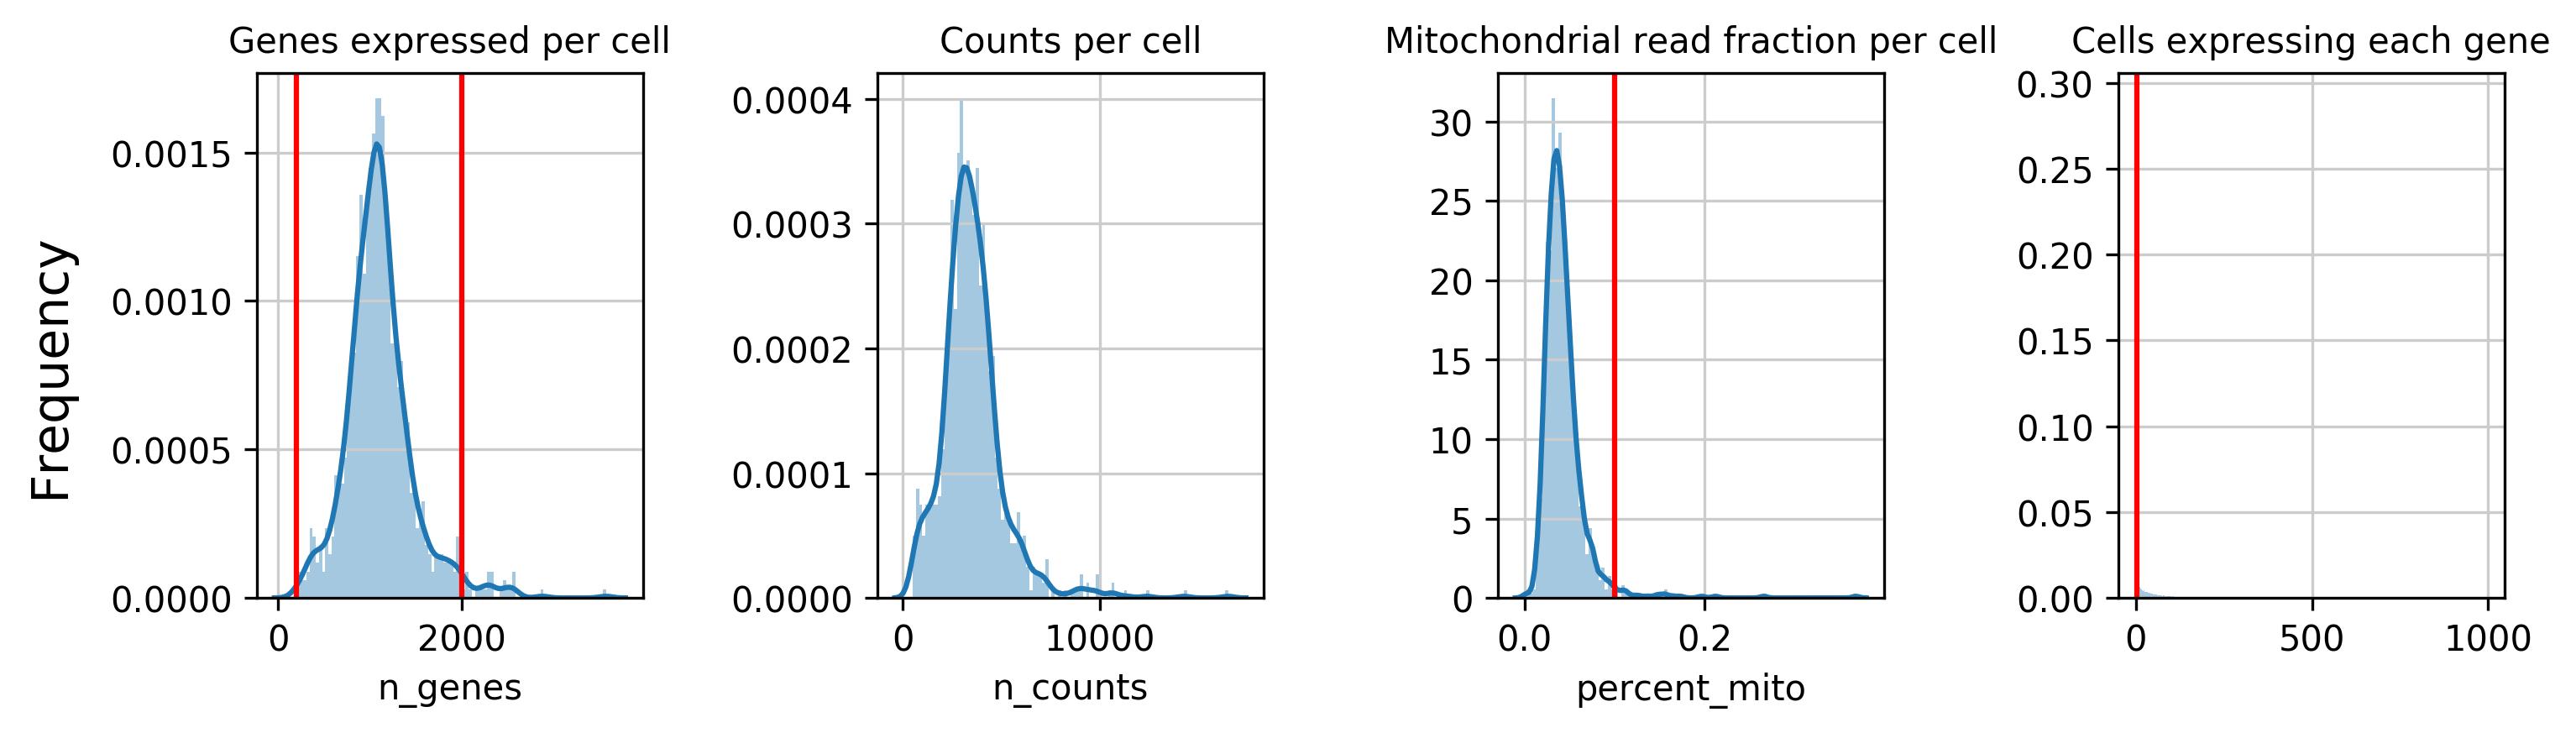

In [8]:
plotSummaryHist(adata_pre, draw_thresholds=True)

#### Summary violin plots showing the distributions of number of genes, number of counts, and fraction of mitochondrial genes

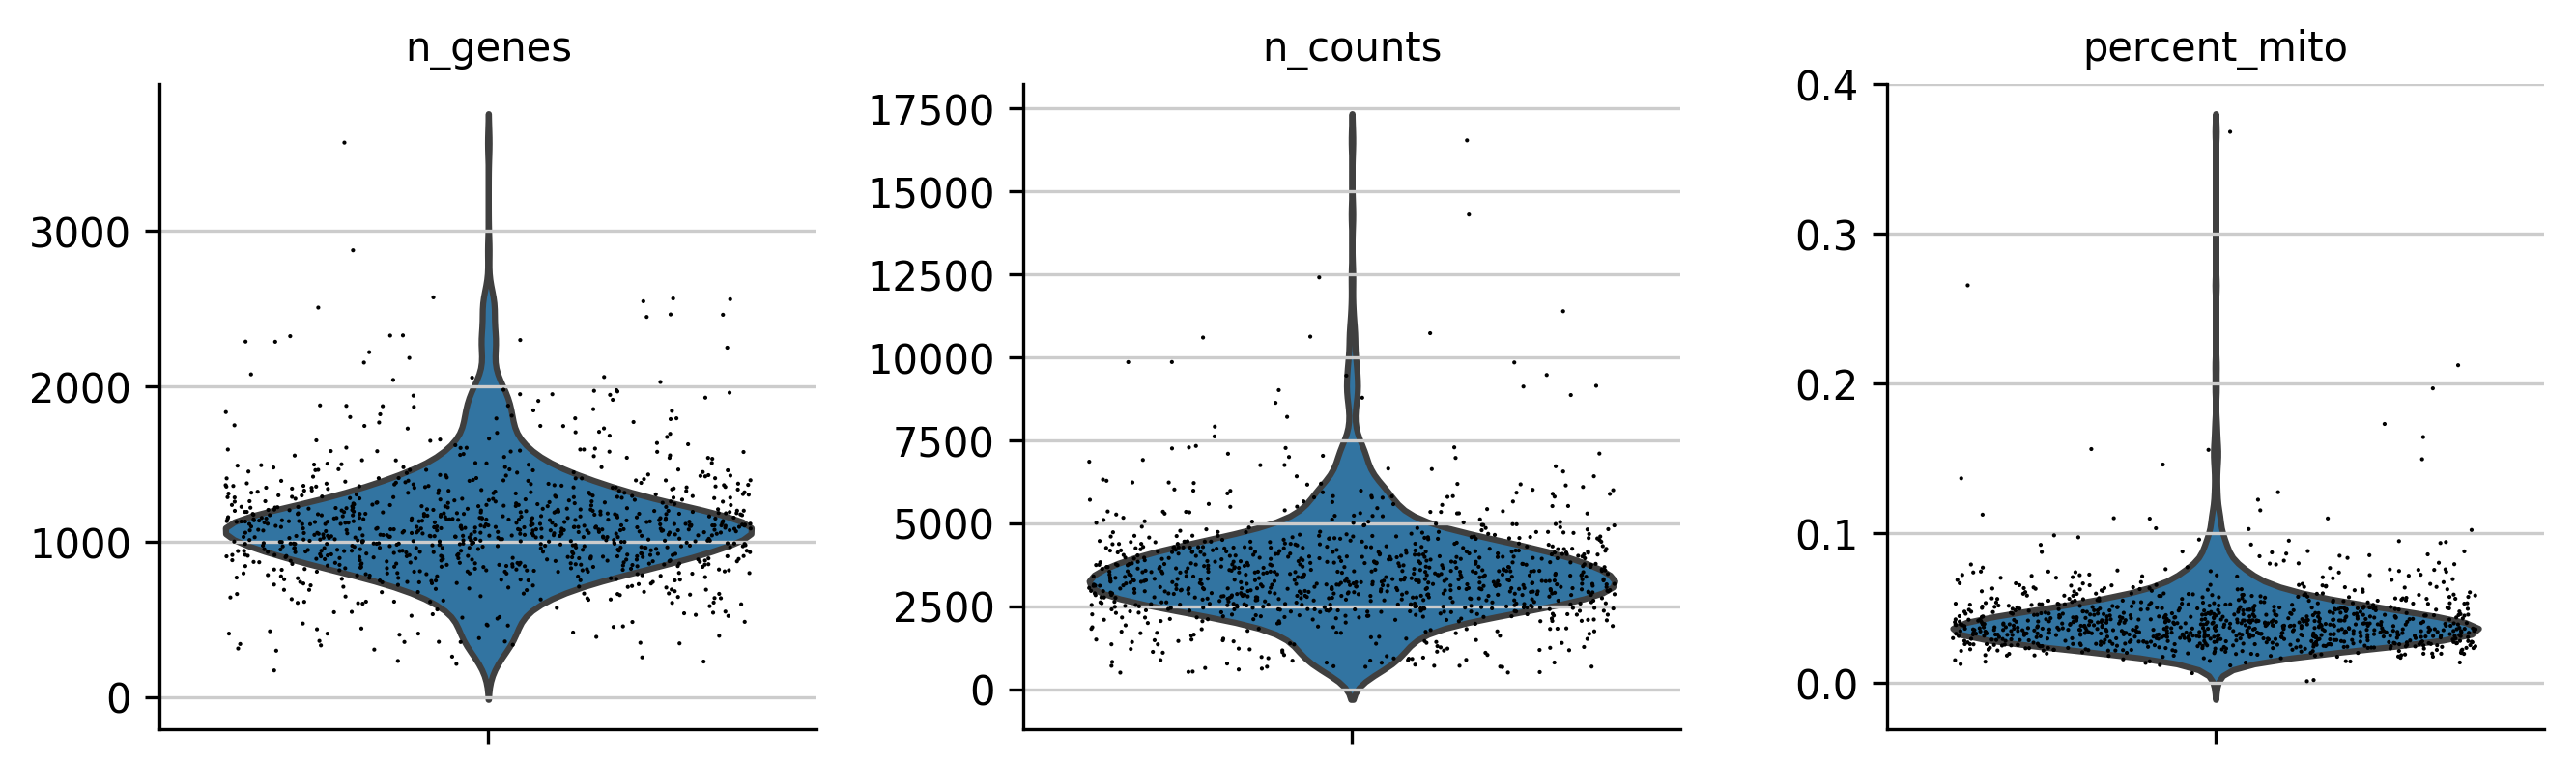

In [9]:
metrics = ['n_genes', 'n_counts', 'percent_mito']
sc.pl.violin(adata_pre, np.array(metrics)[np.isin(metrics,adata_pre.obs.keys())],
    jitter=0.4, multi_panel=True )

#### Scatter plot showing the number of genes vs number of counts, colored by mitochondrial read fraction

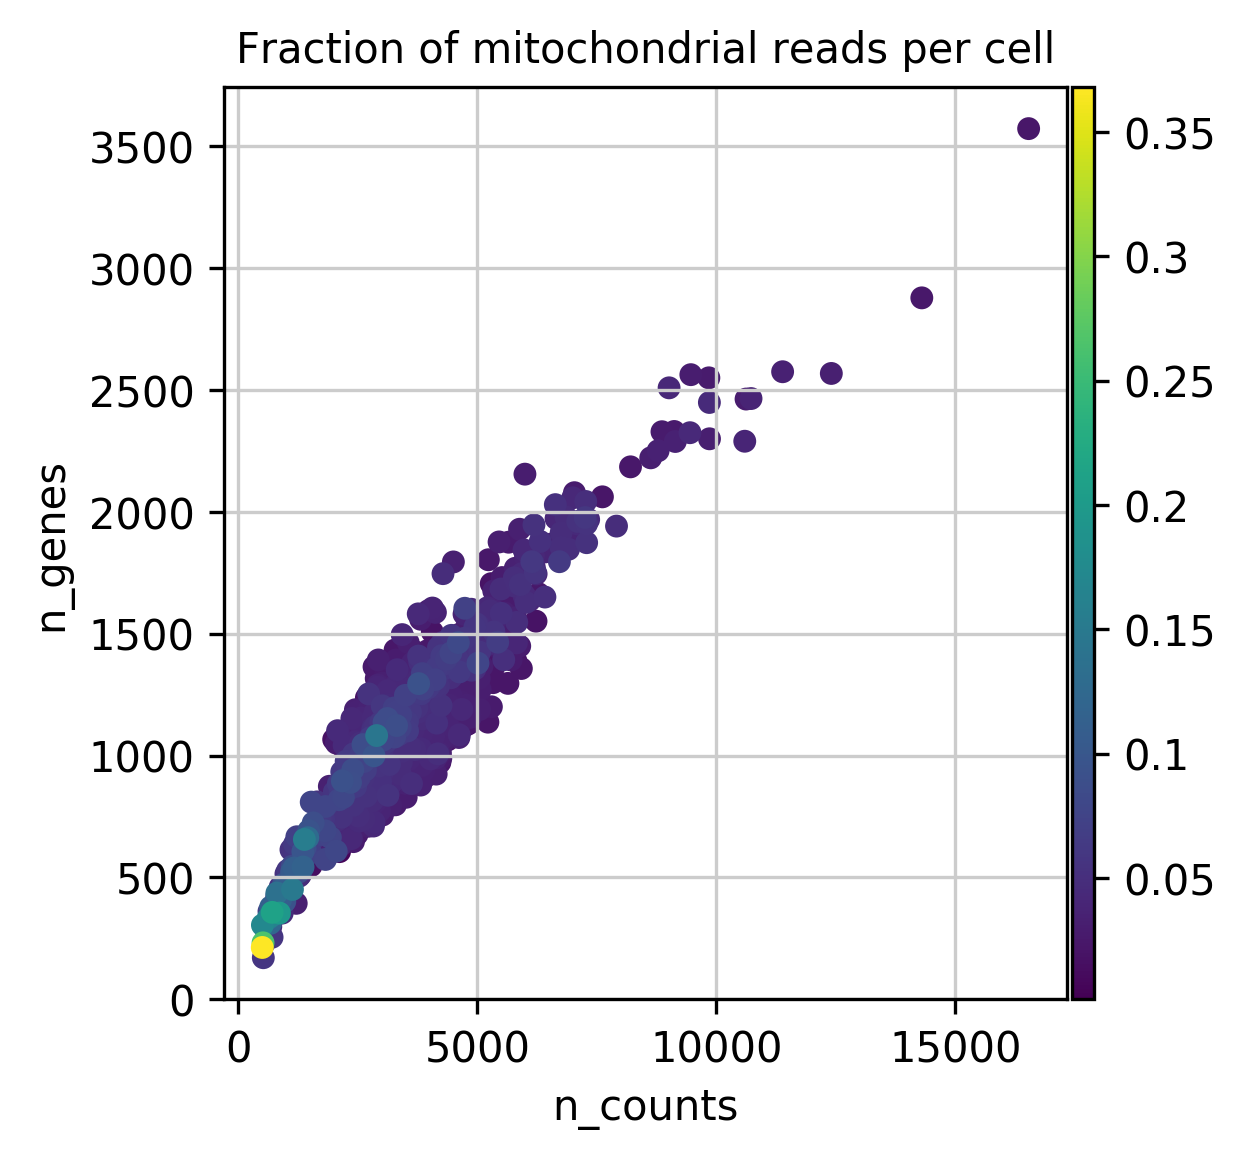

In [10]:
if 'percent_mito' in adata_pre.obs.keys():
    sc.pl.scatter(adata_pre, x='n_counts', y='n_genes', color='percent_mito', title="Fraction of mitochondrial reads per cell")
else:
    sc.pl.scatter(adata_pre, x='n_counts', y='n_genes')
    warnings.warn("Percentage of mitochondrial genes expressed in cells not calculated")

---
## Setting the filters

### Filter 1: Number of genes expressed per cell

**Cell-level filtering**

To determine whether the thresholds are set correctly, it's useful to look at a histogram showing the distribution of the number of genes expressed for each cell. Here, the **left panel** shows the entire range of the data (equivalent to the summary plot above), while the **middle panel** focuses on the area around the lower threshold, and the **right panel** focuses on the area surrounding the upper threshold.

Number of genes expressed per cell threshold is set to 200-2000
Unfiltered data range is 171-3571.


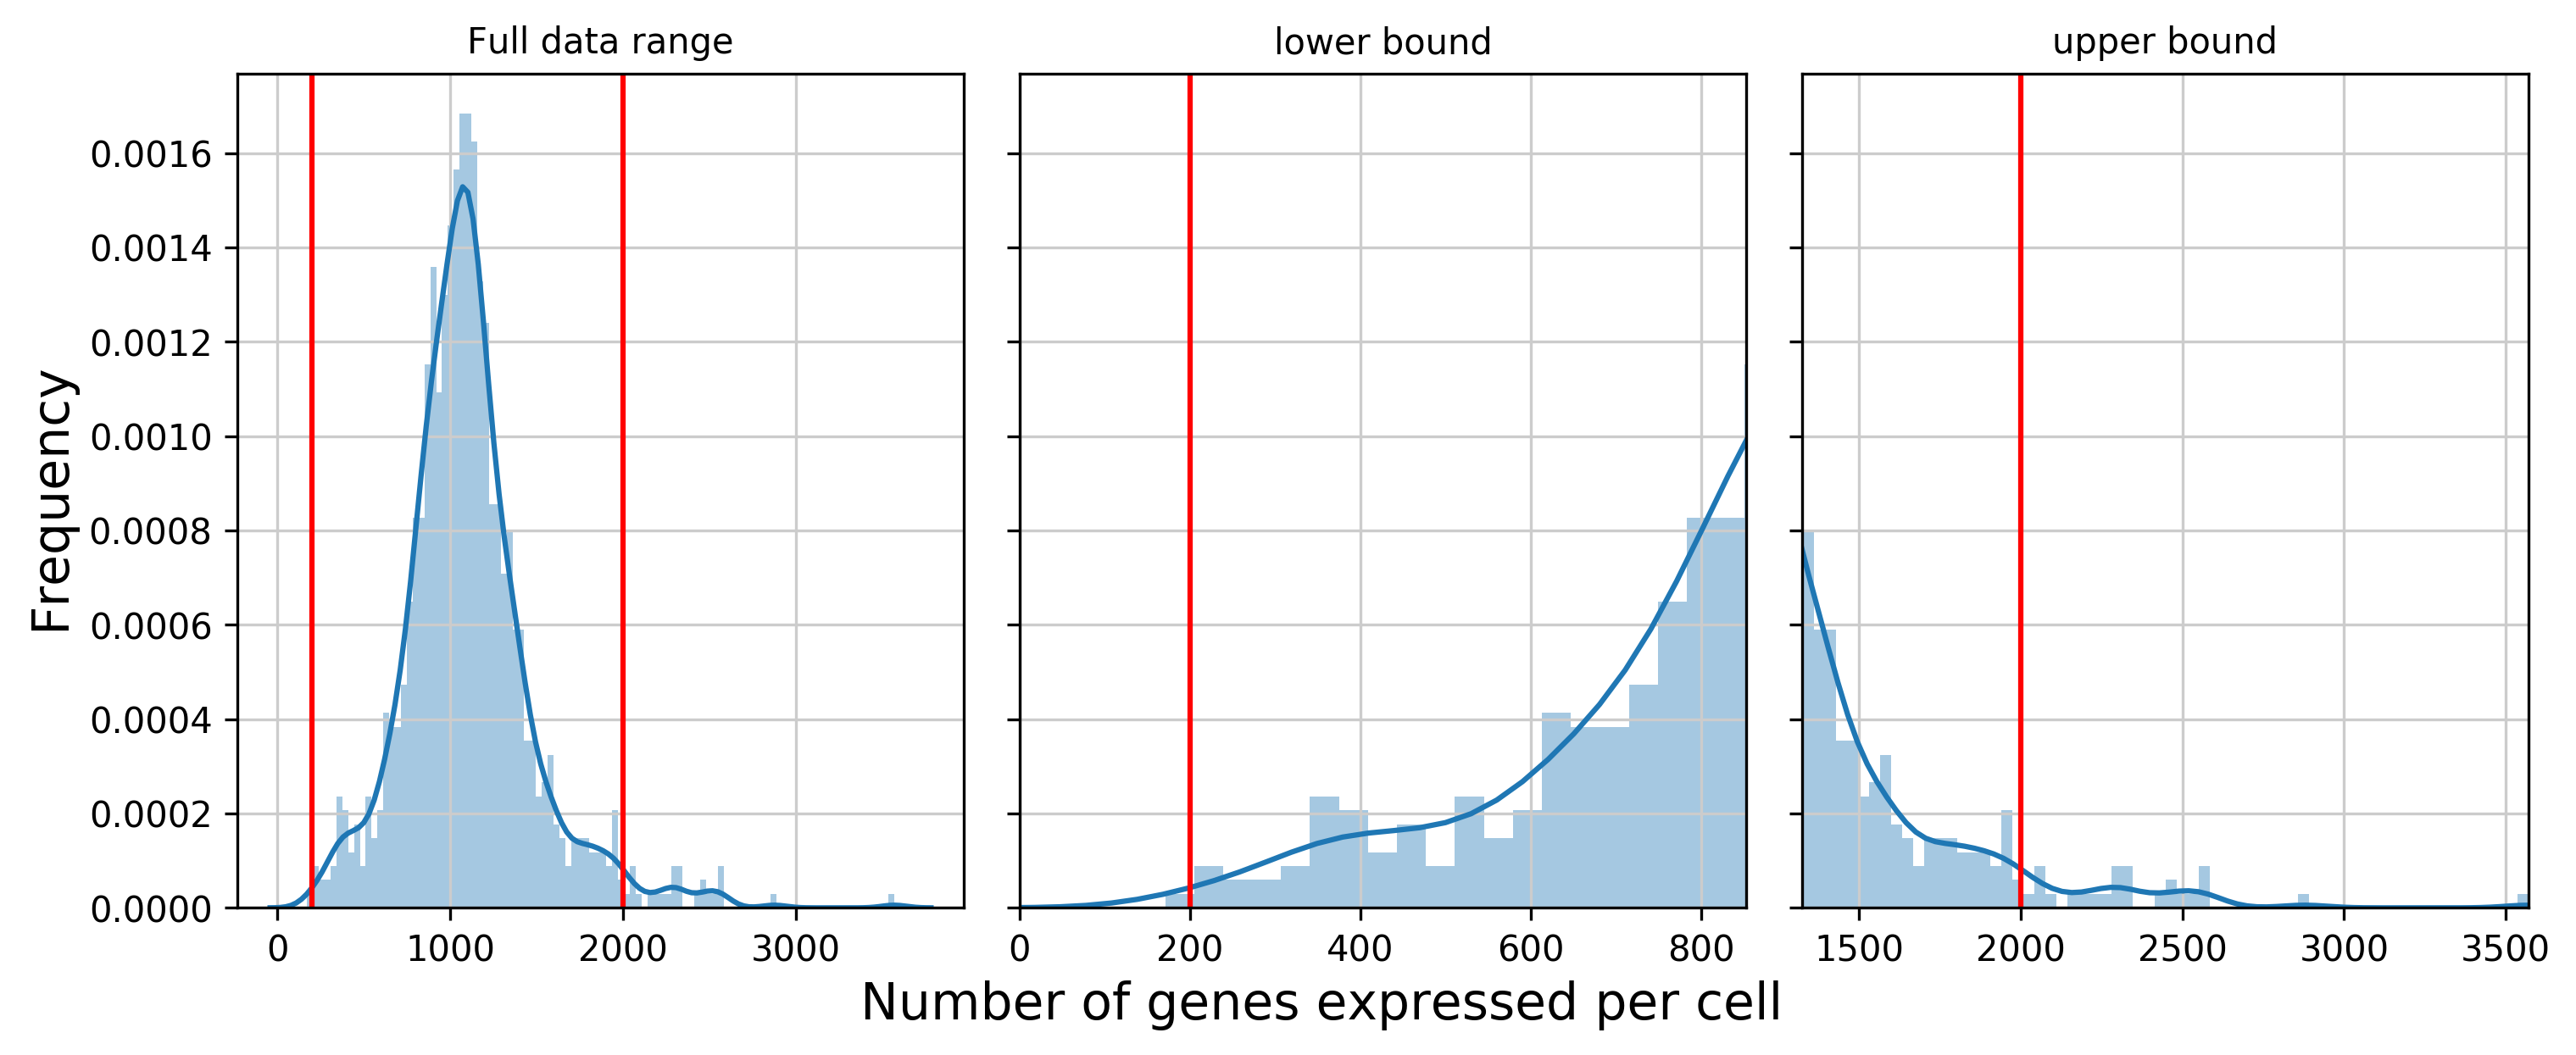

In [11]:
plotDiagnosticHist(adata_pre.obs['n_genes'],
                   xlim_q=0.2, nbins=100,
                   xlab='Number of genes expressed per cell',
                   filter_thr=[ adata_pre.uns['sc']['scanpy']['filter']['cellFilterMinNGenes'],
                                adata_pre.uns['sc']['scanpy']['filter']['cellFilterMaxNGenes']]
                  )
print("Number of genes expressed per cell threshold is set to {}-{}".format(
      adata_pre.uns['sc']['scanpy']['filter']['cellFilterMinNGenes'],
      adata_pre.uns['sc']['scanpy']['filter']['cellFilterMaxNGenes'])
     )
print("Unfiltered data range is {}-{}.".format(adata_pre.obs['n_genes'].min(),adata_pre.obs['n_genes'].max() ))

### Filter 2: Fraction of mitochondrial reads per cell

**Cell-level filtering**

The same approach is used to examine the fraction of mitochondrial reads per cell, focusing on the upper and lower bounds in the right panels. In this case, there is only an upper threshold on mitochondrial read fraction.

Fraction of mitochondrial reads per cell threshold limit is set to 0.1
Unfiltered data range is 0.0012410797644406557-0.36800000071525574.


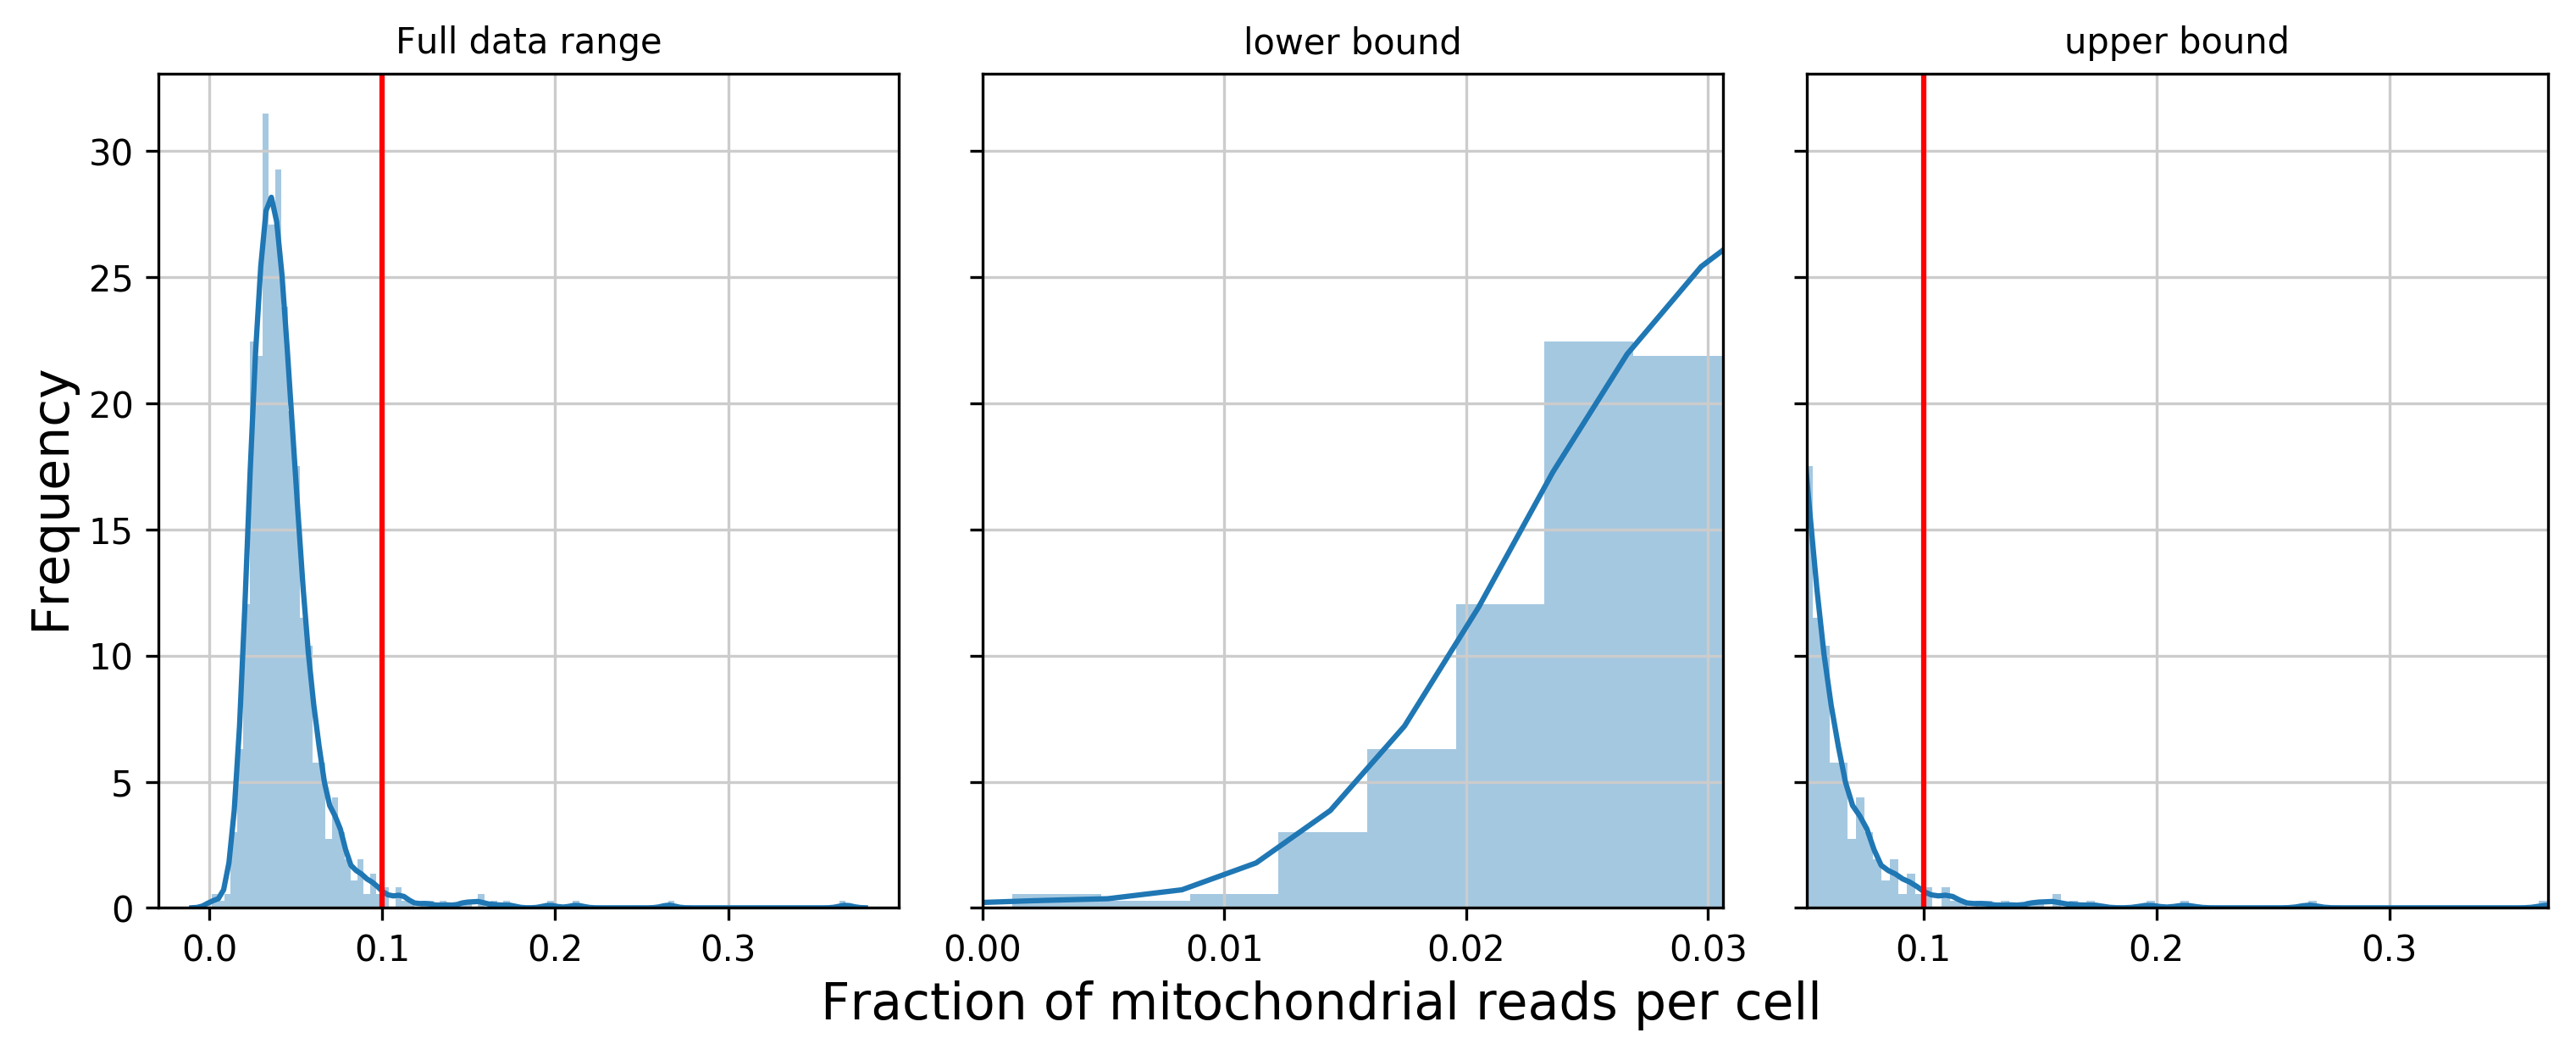

In [12]:
if 'percent_mito' in adata_pre.obs.keys():
    plotDiagnosticHist(adata_pre.obs['percent_mito'],
                       xlim_q=0.25, nbins=100,
                       xlab='Fraction of mitochondrial reads per cell',
                       filter_thr=adata_pre.uns['sc']['scanpy']['filter']['cellFilterMaxPercentMito'])
    print("Fraction of mitochondrial reads per cell threshold limit is set to {}".format(
      adata_pre.uns['sc']['scanpy']['filter']['cellFilterMaxPercentMito'])
     )
    print("Unfiltered data range is {}-{}.".format(adata_pre.obs['percent_mito'].min(),adata_pre.obs['percent_mito'].max() ))
else:
    warnings.warn("Percentage of mitochondrial genes expressed in cells not calculated")

### Filter 3: Number of cells expressing each gene

**Gene-level filtering**

The final filter is applied on a gene-level: For each gene, we count the number of cells in which it is expressed. The distribution here is usually highly skewed, such that there are a large number of genes expressed in only a few cells (with many expressed in 0 or 1 cells). The threshold here can be conservatively set low: requiring a minimum of **3** cells expressing any given gene is a reasonable start, but this will be highly dependent on the data, particularly the total number of cells in the experiment.

The same approach is used as above, focusing on the upper and lower bounds in the right panels. In this case, there is only an upper threshold on number of cells expressing each gene. The _upper bound_ plot is not as useful here.

Keeping genes present in at least 3 cells
Unfiltered data range is 0-996.


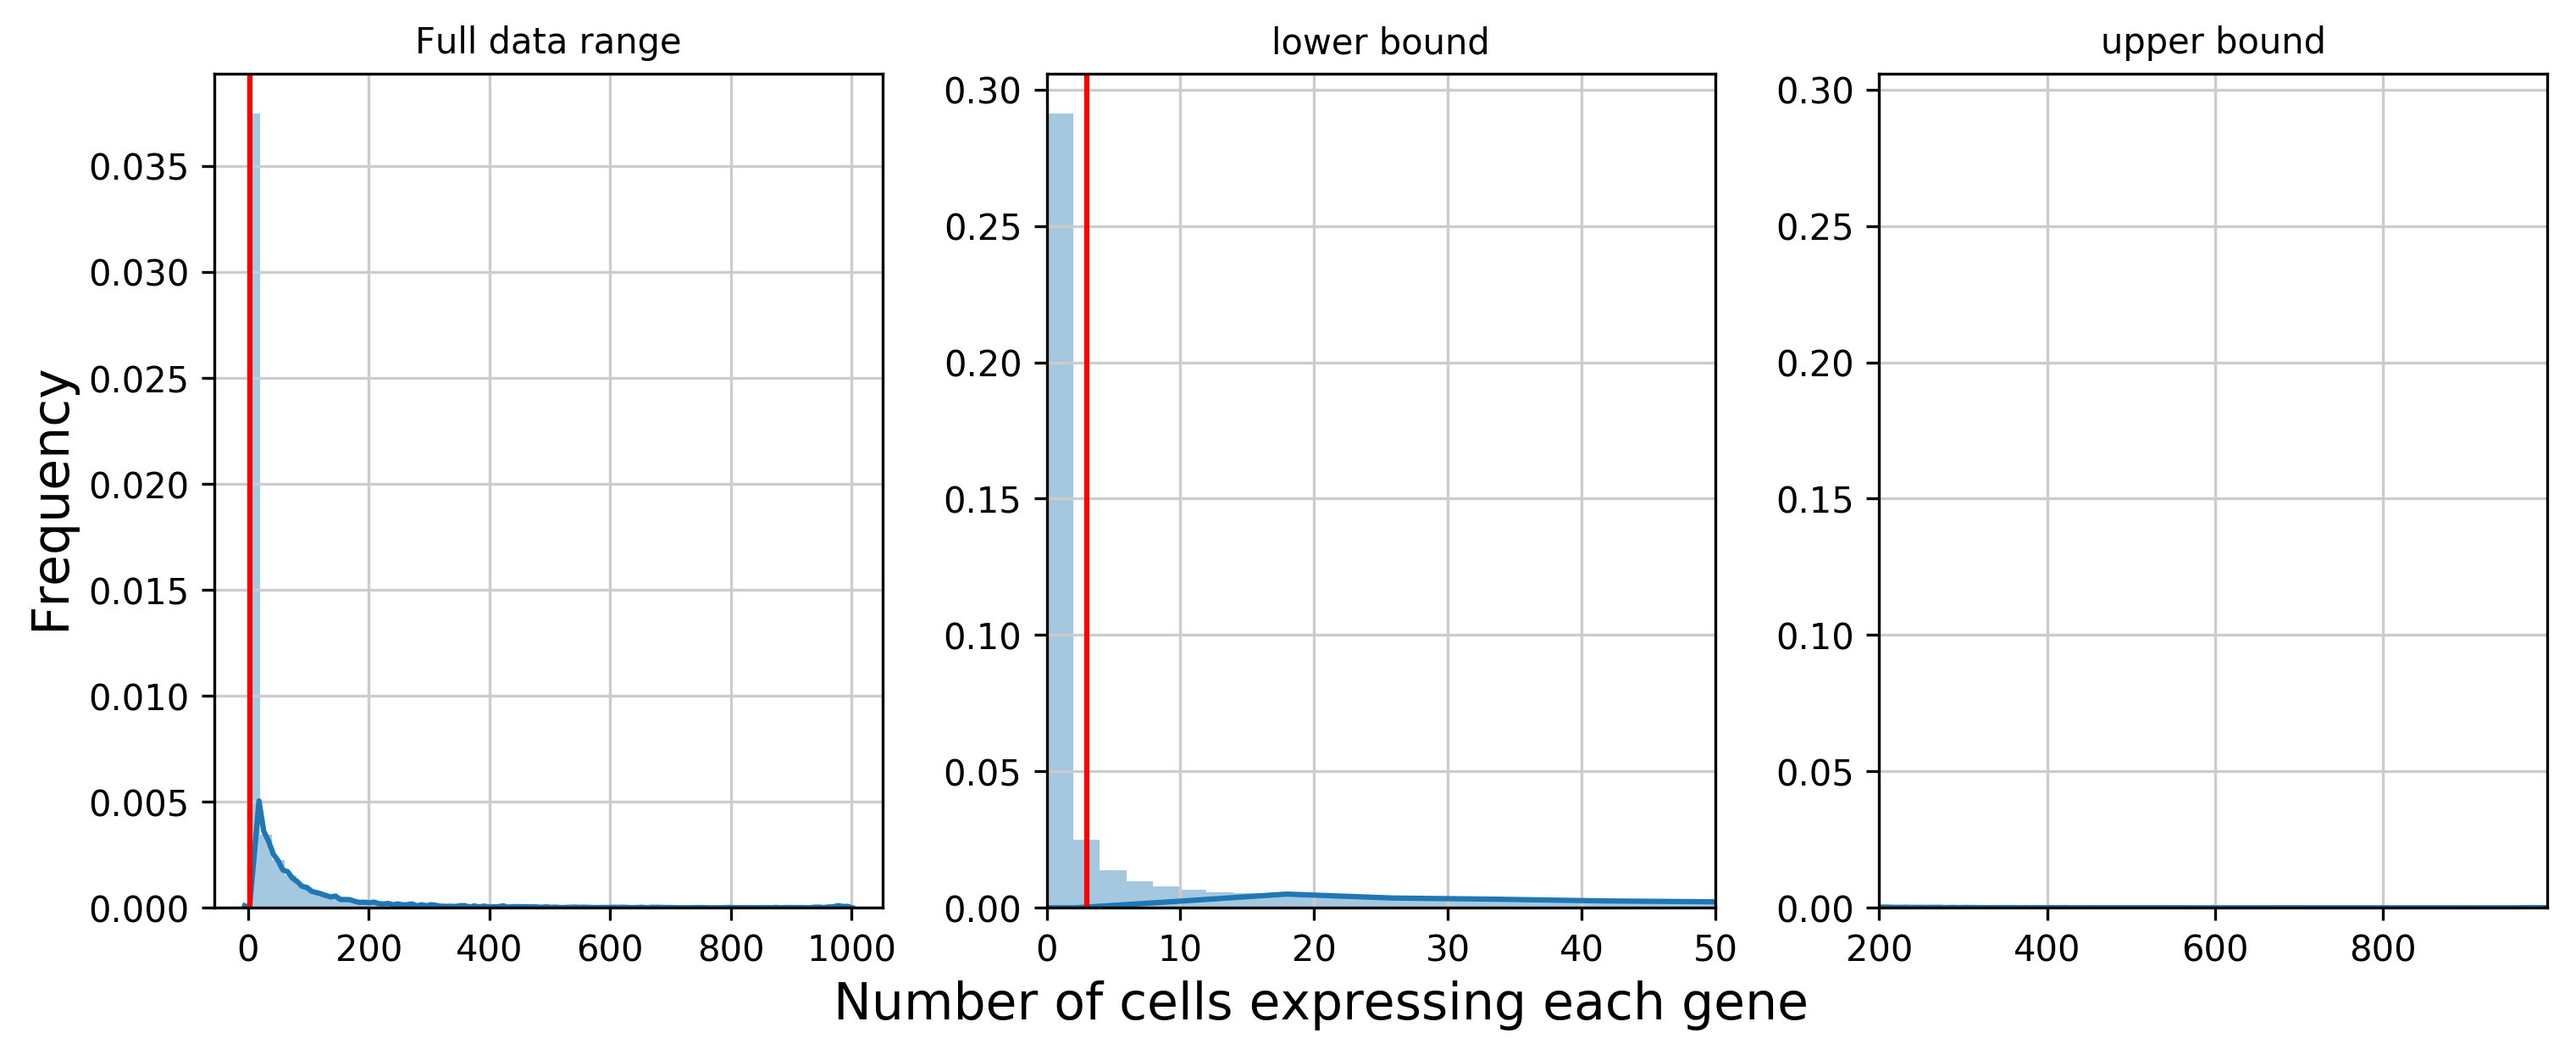

In [13]:
plotDiagnosticHist(nCellsPerGene,
                   xlim_val=[50,200], nbins=[50,500,500],
                   xlab='Number of cells expressing each gene',
                   filter_thr=adata_pre.uns['sc']['scanpy']['filter']['geneFilterMinNCells']
                  )

print("Keeping genes present in at least {} cells".format(adata_pre.uns['sc']['scanpy']['filter']['geneFilterMinNCells'] ))
print("Unfiltered data range is {}-{}.".format(nCellsPerGene.min(),nCellsPerGene.max() ))

---
## Diagnostic Plots (post-filtering)

Here, we show repeat the summary plots shown above, this time showing the data **after filting**.

In [14]:
# re-calculate number of cells per gene for post-filter:
nCellsPerGene = pd.Series( np.sum(adata_post.X>0, axis=0).tolist()[0], index=adata_post.var_names )

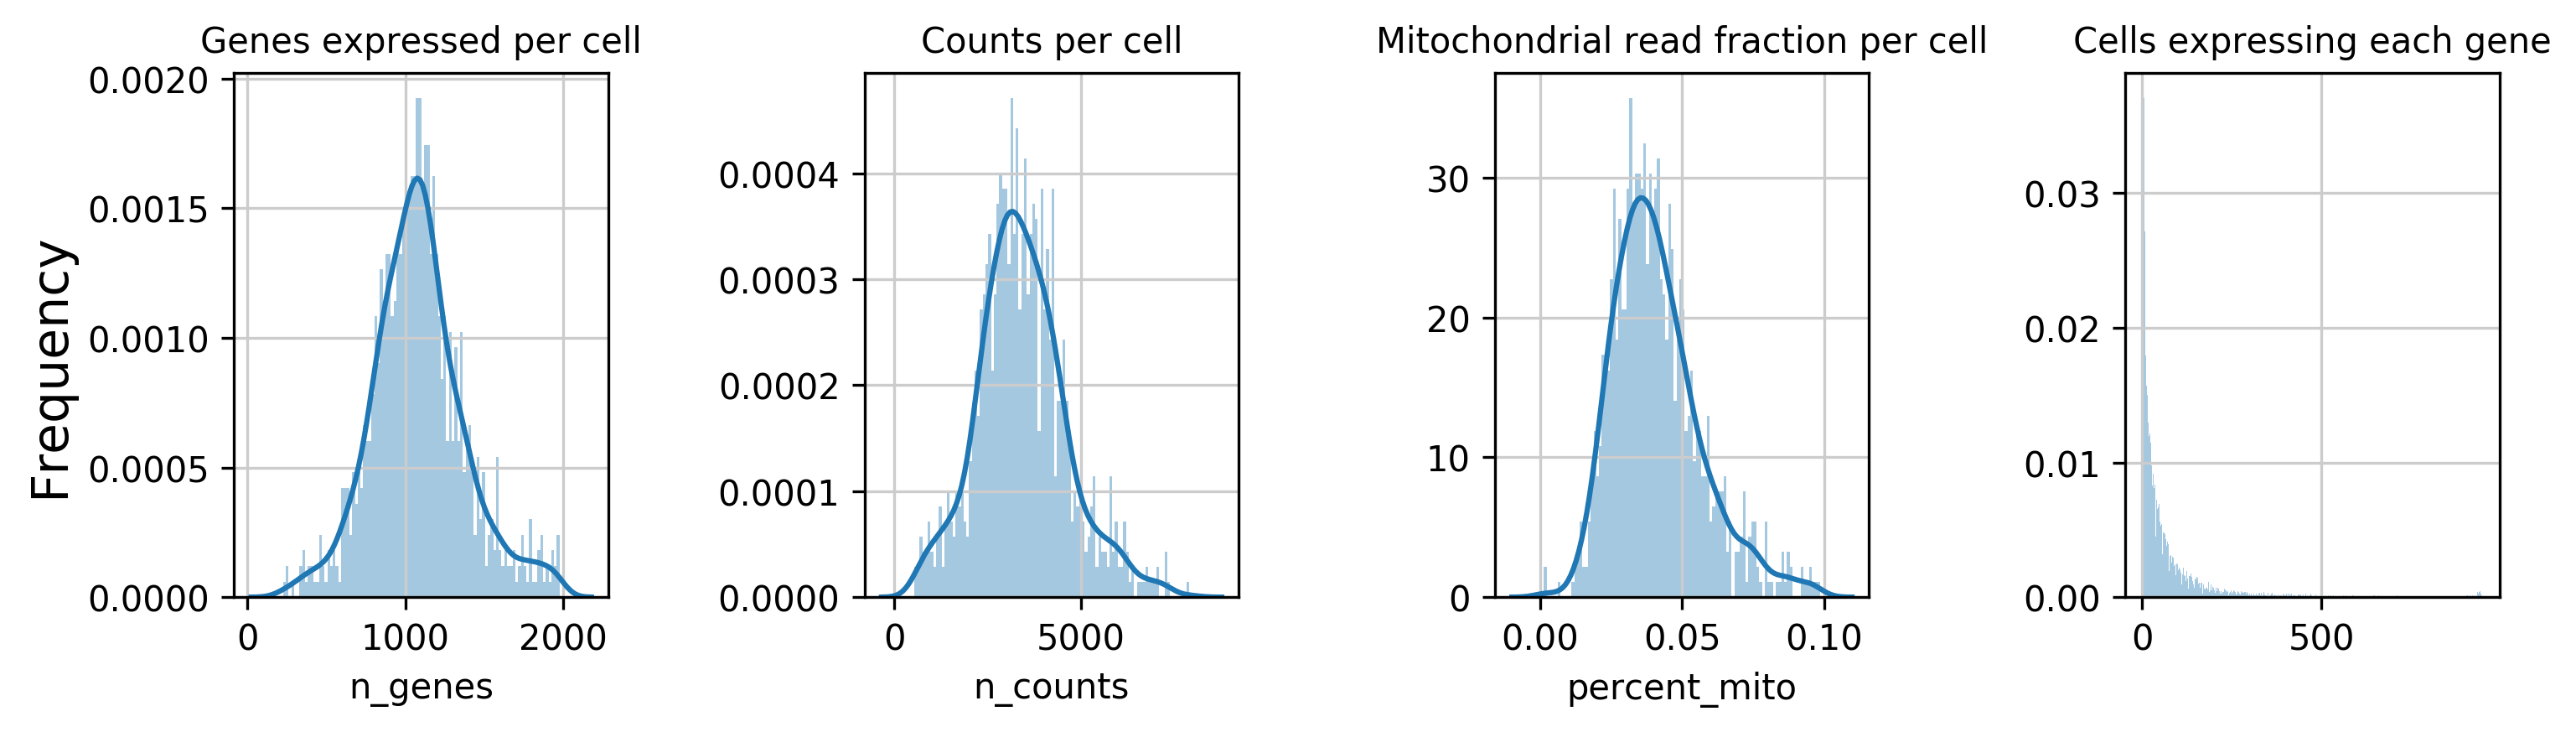

In [15]:
plotSummaryHist(adata_post)

#### Violin plots of number of genes, number of counts, and percent of mitochondrial genes

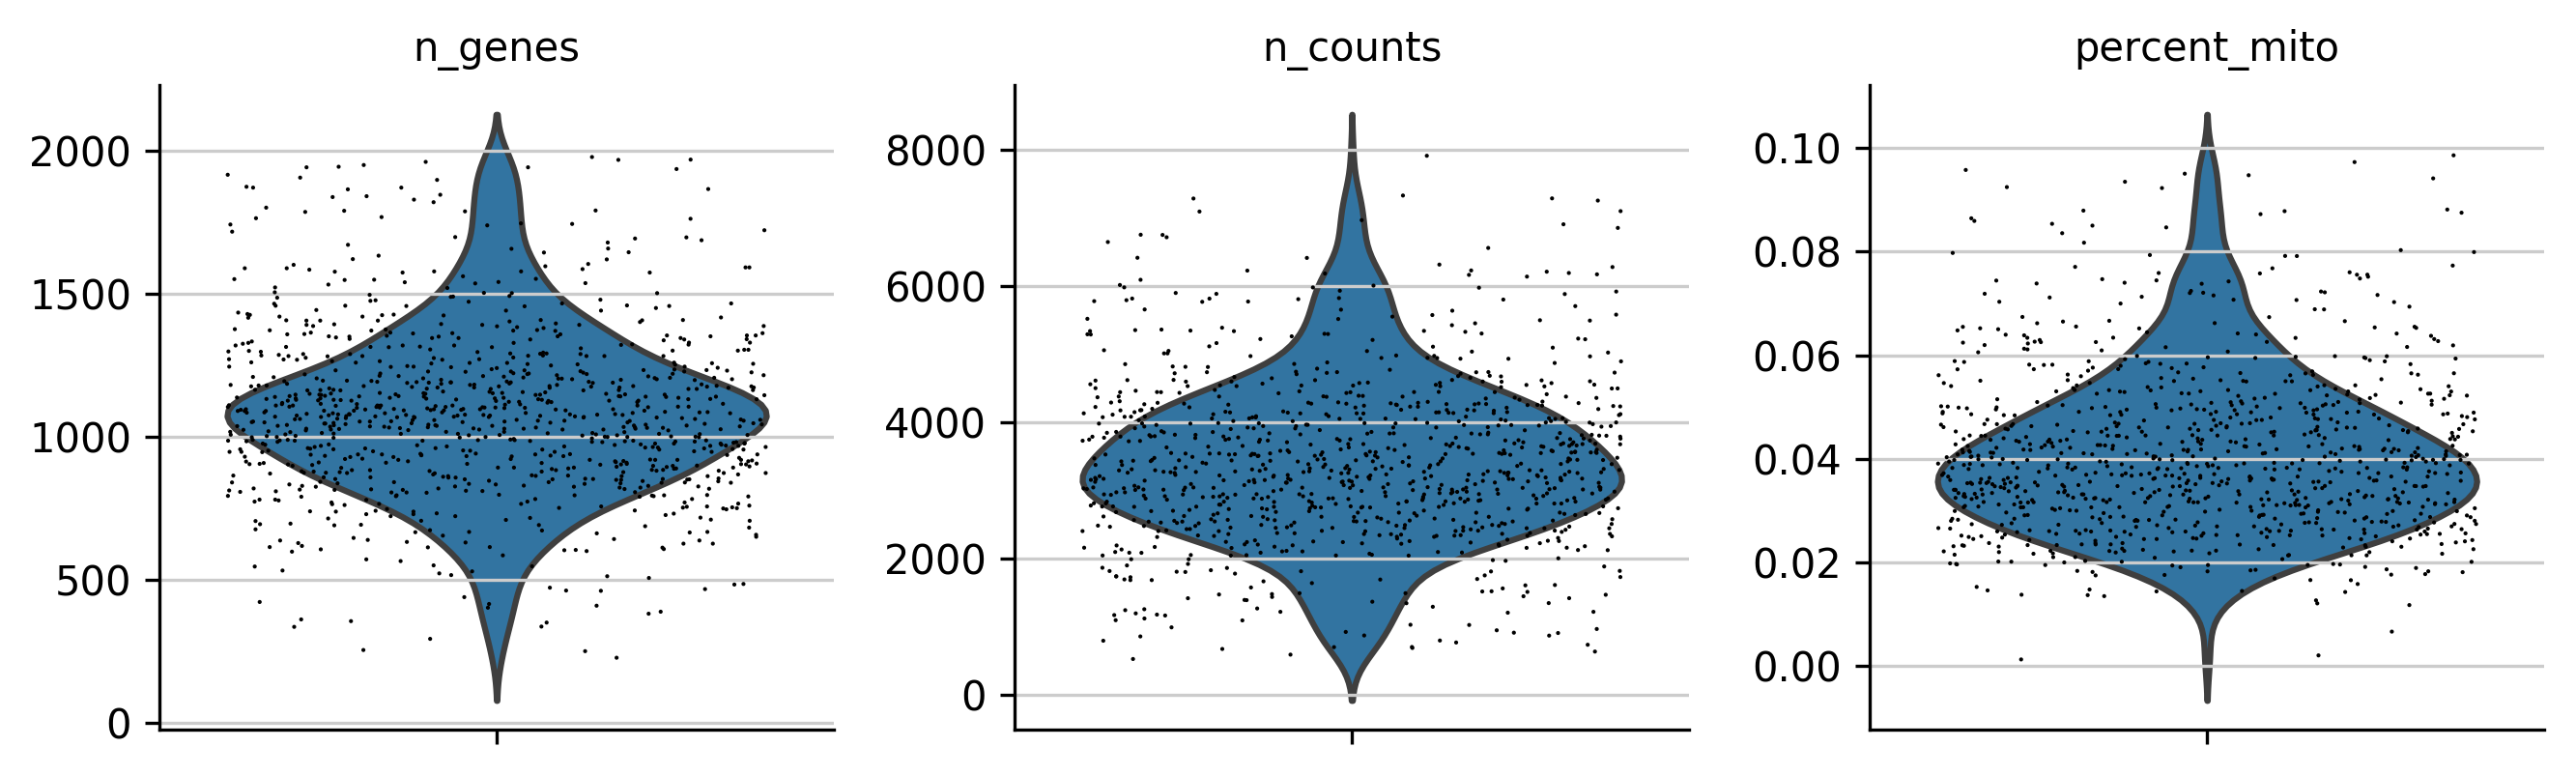

In [16]:
metrics = ['n_genes', 'n_counts', 'percent_mito']
sc.pl.violin(adata_post, np.array(['n_genes', 'n_counts', 'percent_mito'])[np.isin(metrics,adata_post.obs.keys())],
    jitter=0.4, multi_panel=True )

#### Scatter plot number of genes vs number of counts

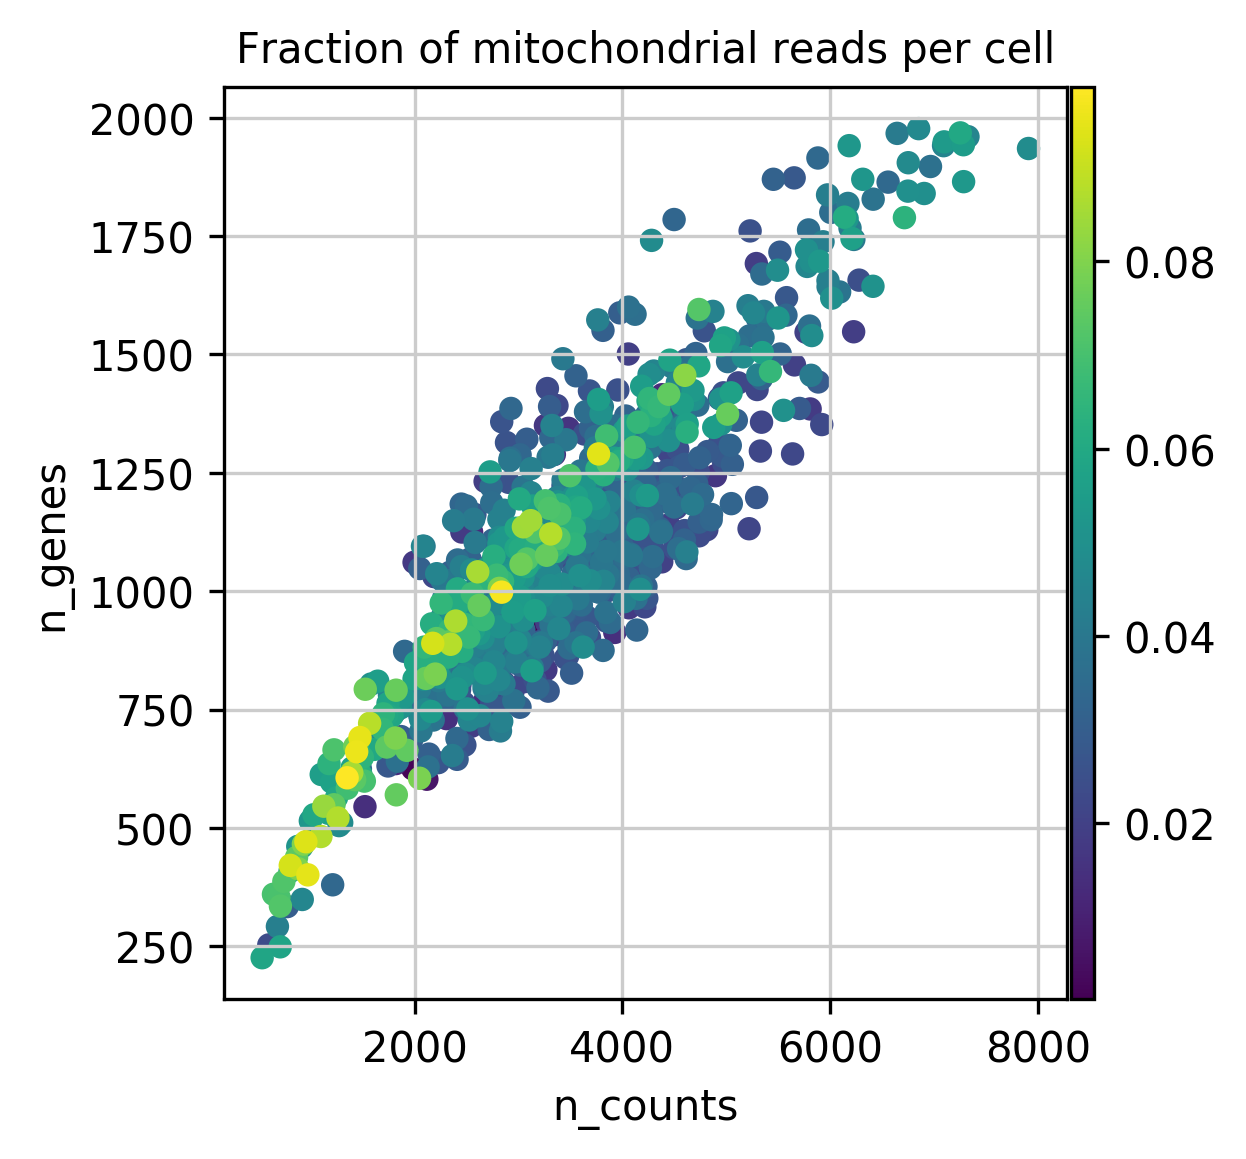

In [17]:
if 'percent_mito' in adata_post.obs.keys():
    sc.pl.scatter(adata_post, x='n_counts', y='n_genes', color='percent_mito', title="Fraction of mitochondrial reads per cell")
else:
    sc.pl.scatter(adata_post, x='n_counts', y='n_genes')
    warnings.warn("Percentage of mitochondrial genes expressed in cells not calculated")

In [1]:
# Parameters
FILE = "1k_pbmc_v2_chemistry.SC__SCANPY__FEATURE_SCALING.h5ad"


# Single-Cell Report: Highly variable gene selection

In [2]:
# Import packages
import scanpy as sc
import numpy as np

/opt/venv/lib/python3.7/site-packages/louvain/Optimiser.py:349: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(issubclass(partition_type, LinearResolutionParameterVertexPartition),


#### Plotting settings and functions

In [3]:
# plot settings
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)

#### Read Data

In [4]:
adata = sc.read_h5ad(filename=FILE)

---
## Highly variable genes selection

In [5]:
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))


 Number of highly variable genes: 2444


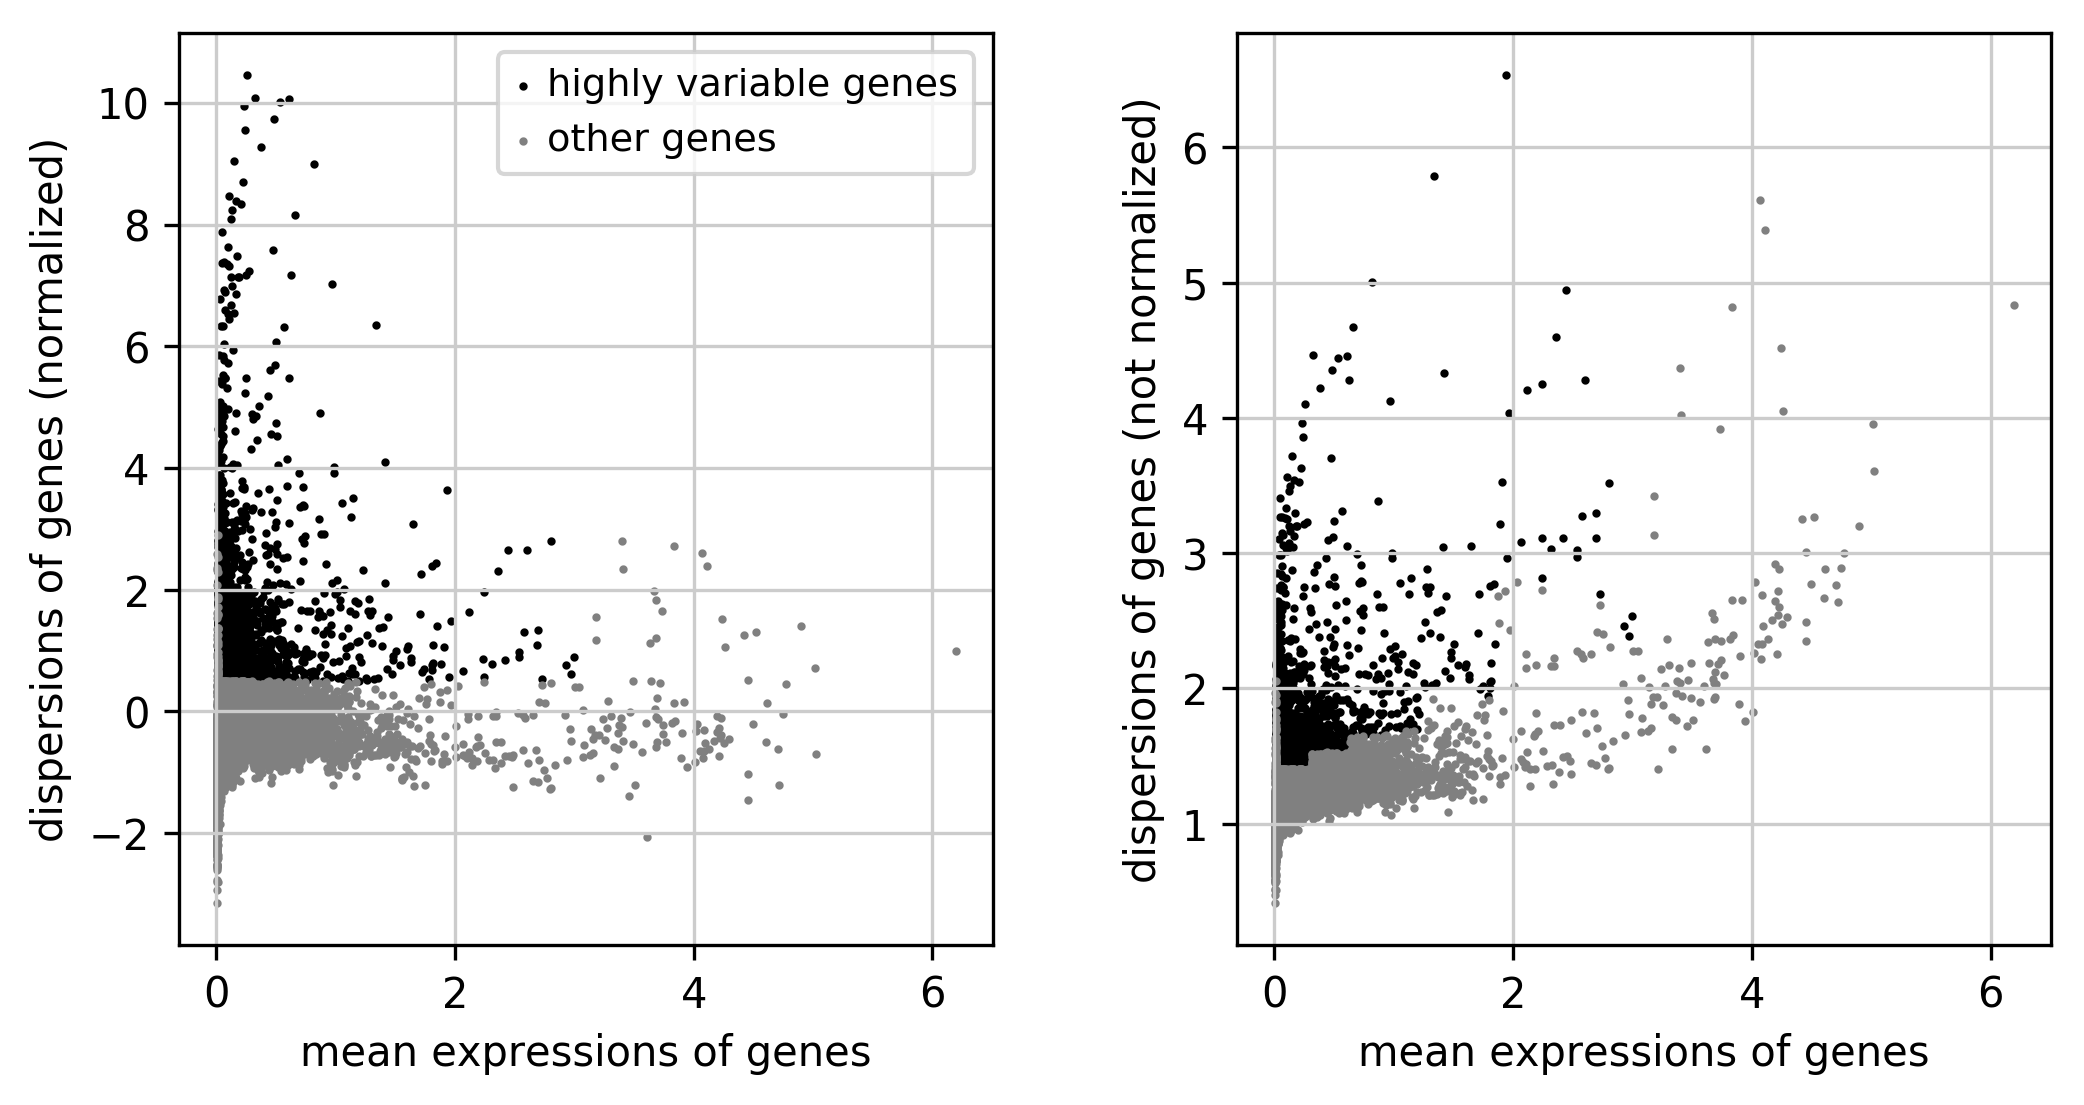

In [6]:
sc.pl.highly_variable_genes(adata)

In [1]:
# Parameters
FILE = "1k_pbmc_v2_chemistry.SC__SCANPY__DIM_REDUCTION_UMAP.h5ad"


# Single-Cell Report: Dimensionality reduction

In [2]:
# Import packages
import scanpy as sc

/opt/venv/lib/python3.7/site-packages/louvain/Optimiser.py:349: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(issubclass(partition_type, LinearResolutionParameterVertexPartition),


#### Plotting settings and functions

In [3]:
# plot settings
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)

#### Read Data

In [4]:
adata = sc.read_h5ad(filename=FILE)

In [5]:
# select features to show in the plots below
features = ['n_genes','n_counts','percent_mito'] #,'louvain']

---
## PCA

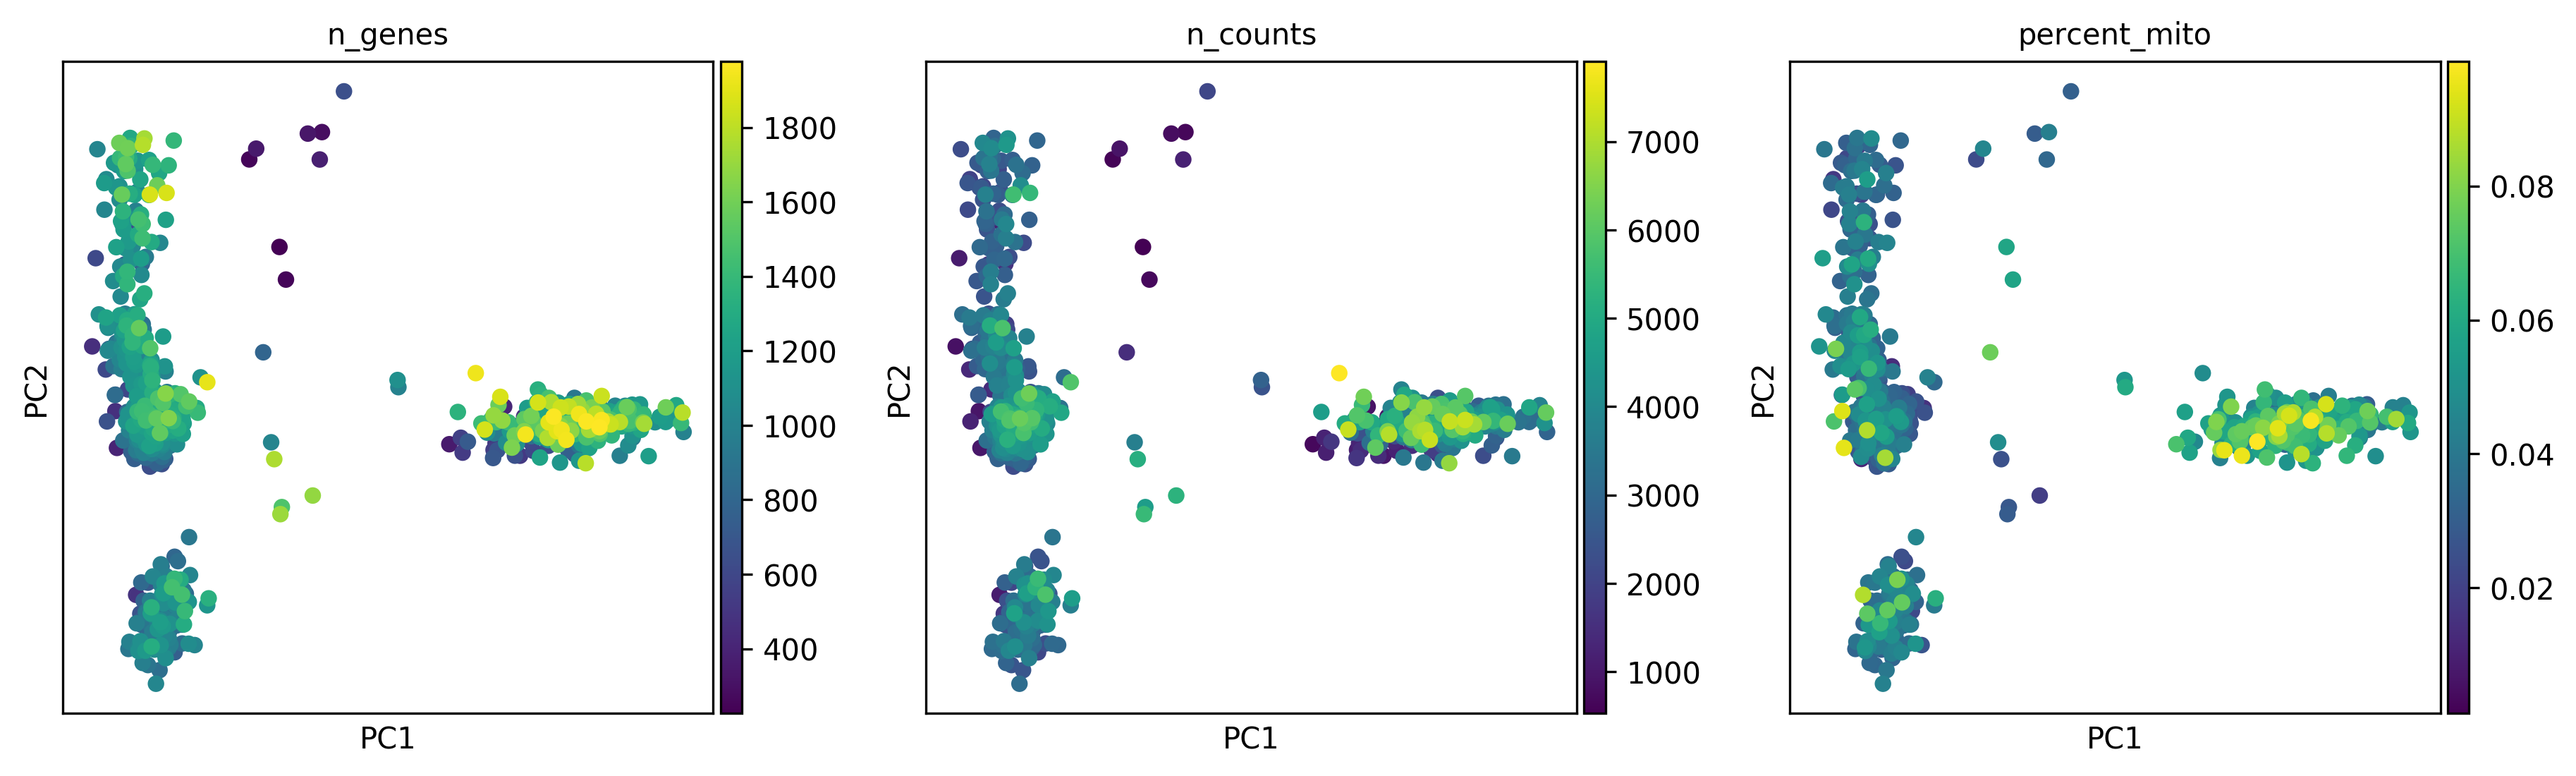

In [6]:
if('X_pca' in adata.obsm):
    sc.pl.pca_scatter(adata, color=features)

---
## t-SNE

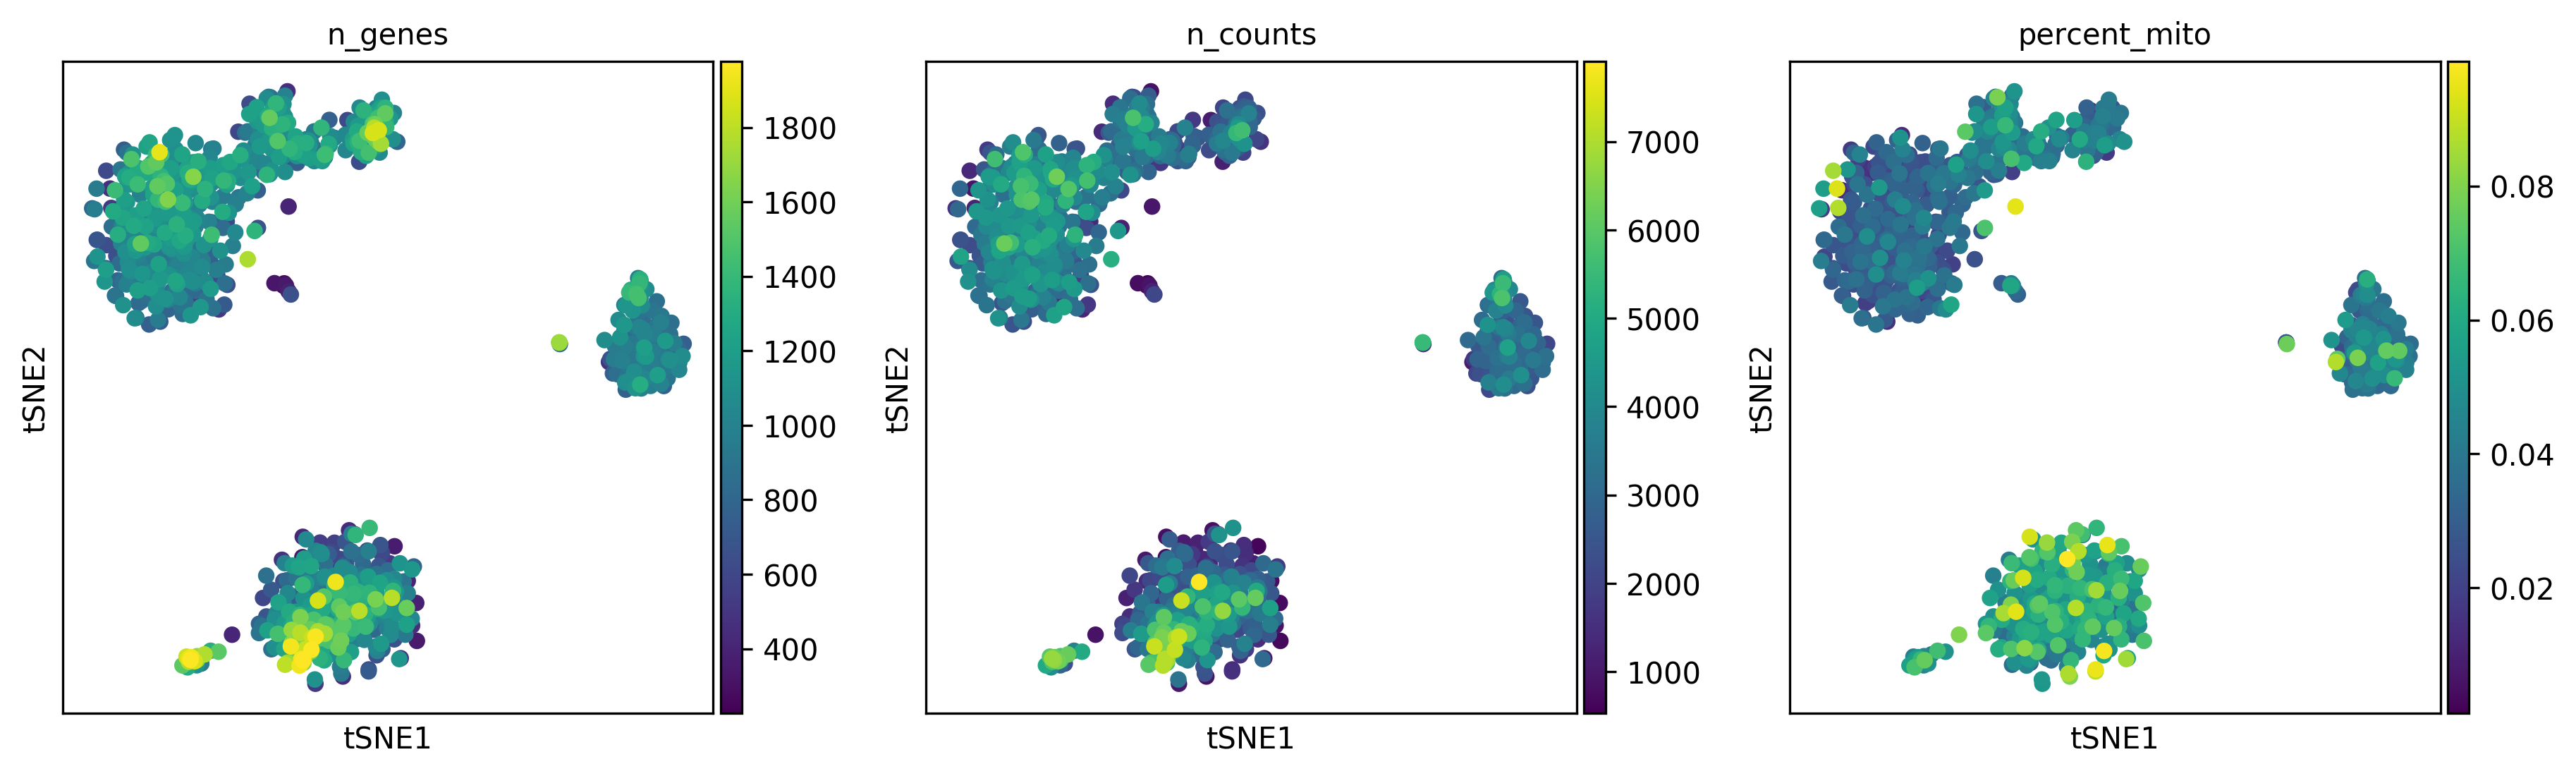

In [7]:
if('X_tsne' in adata.obsm):
    sc.pl.tsne(adata, color=features)

---
## UMAP

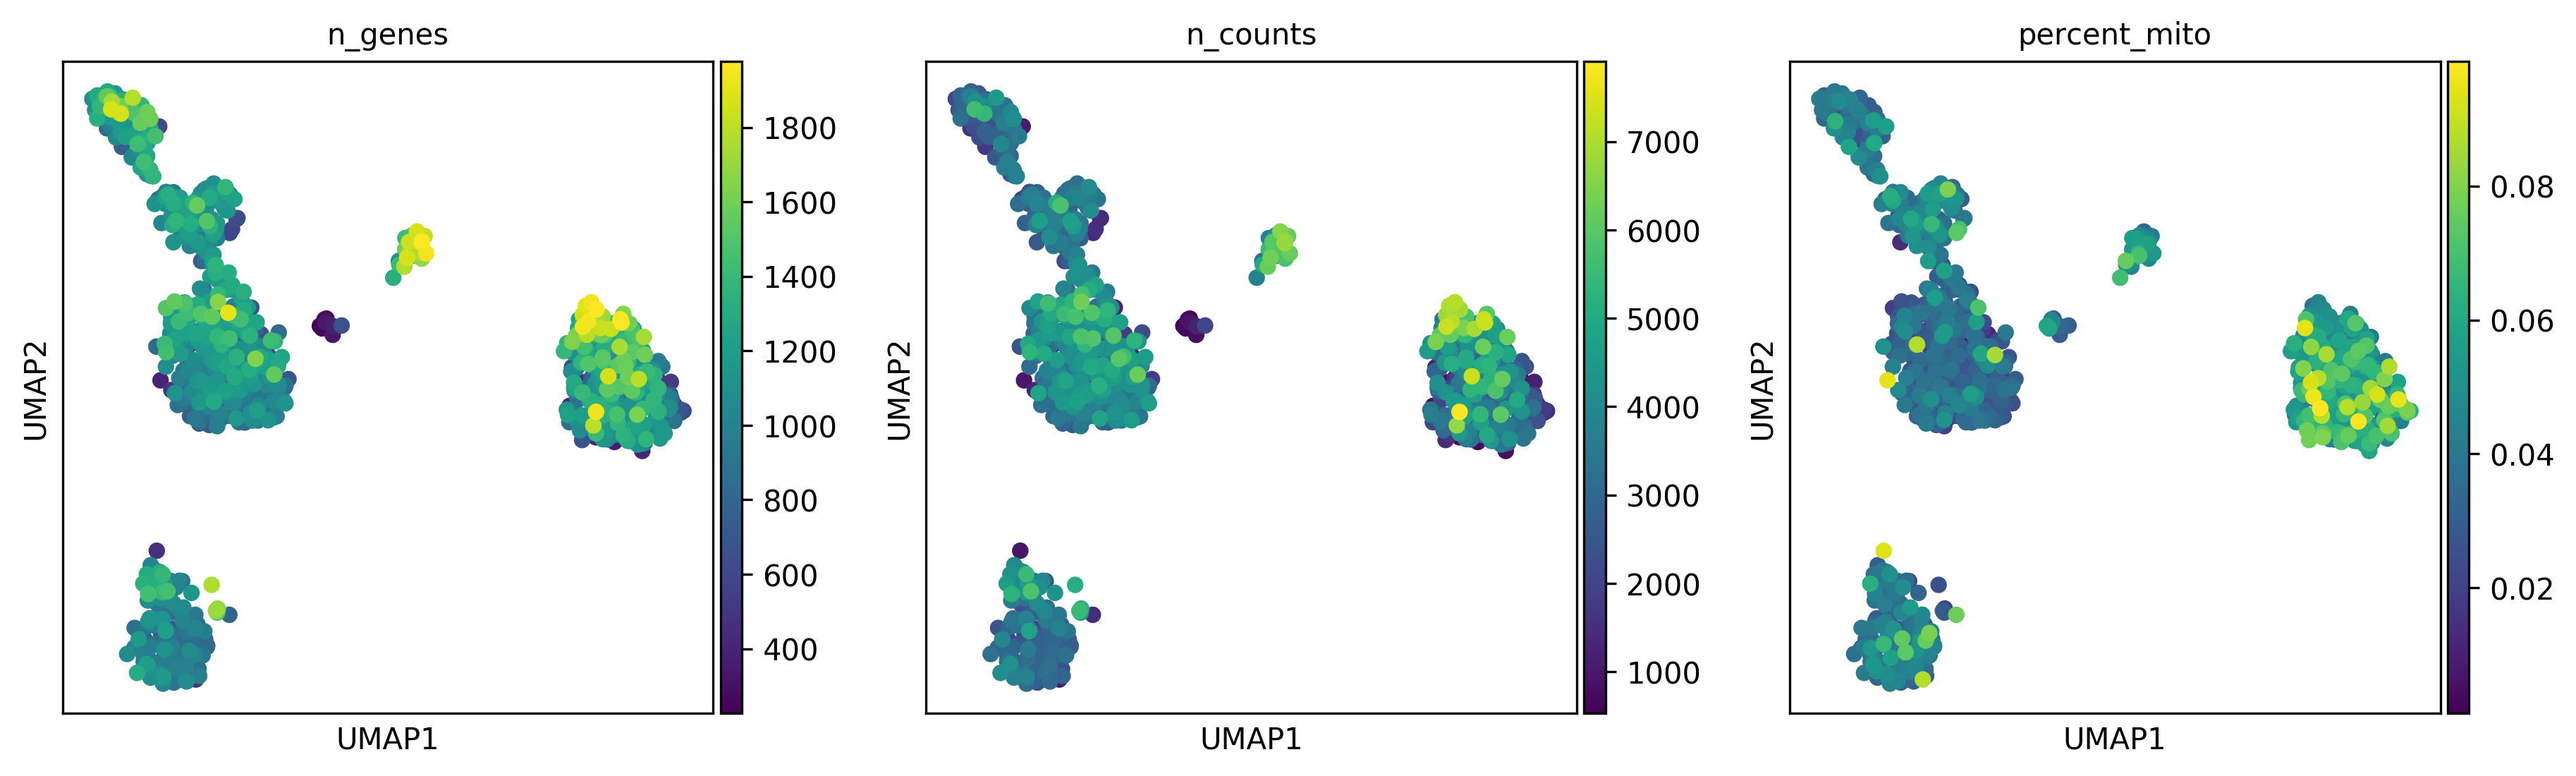

In [8]:
if('X_umap' in adata.obsm):
    sc.pl.umap(adata, color=features)

In [9]:
### Future additions (not yet present in adata)
#sc.pl.diffmap(adata, color=features, components=['1,2','1,3'])
#sc.pl.draw_graph(adata, color=features)

In [1]:
# Parameters
FILE = "1k_pbmc_v2_chemistry.SC__SCANPY__CLUSTERING.h5ad"


# Single-Cell Report: Clustering

In [2]:
# Import packages
import scanpy as sc

/opt/venv/lib/python3.7/site-packages/louvain/Optimiser.py:349: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(issubclass(partition_type, LinearResolutionParameterVertexPartition),


#### Plotting settings and functions

In [3]:
# plot settings
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)

#### Read Data

In [4]:
adata = sc.read_h5ad(filename=FILE)

In [5]:
# select features to show in the plots below
features = ['louvain','n_counts','percent_mito']

---
## Clustering

Louvain resolution: 0.8


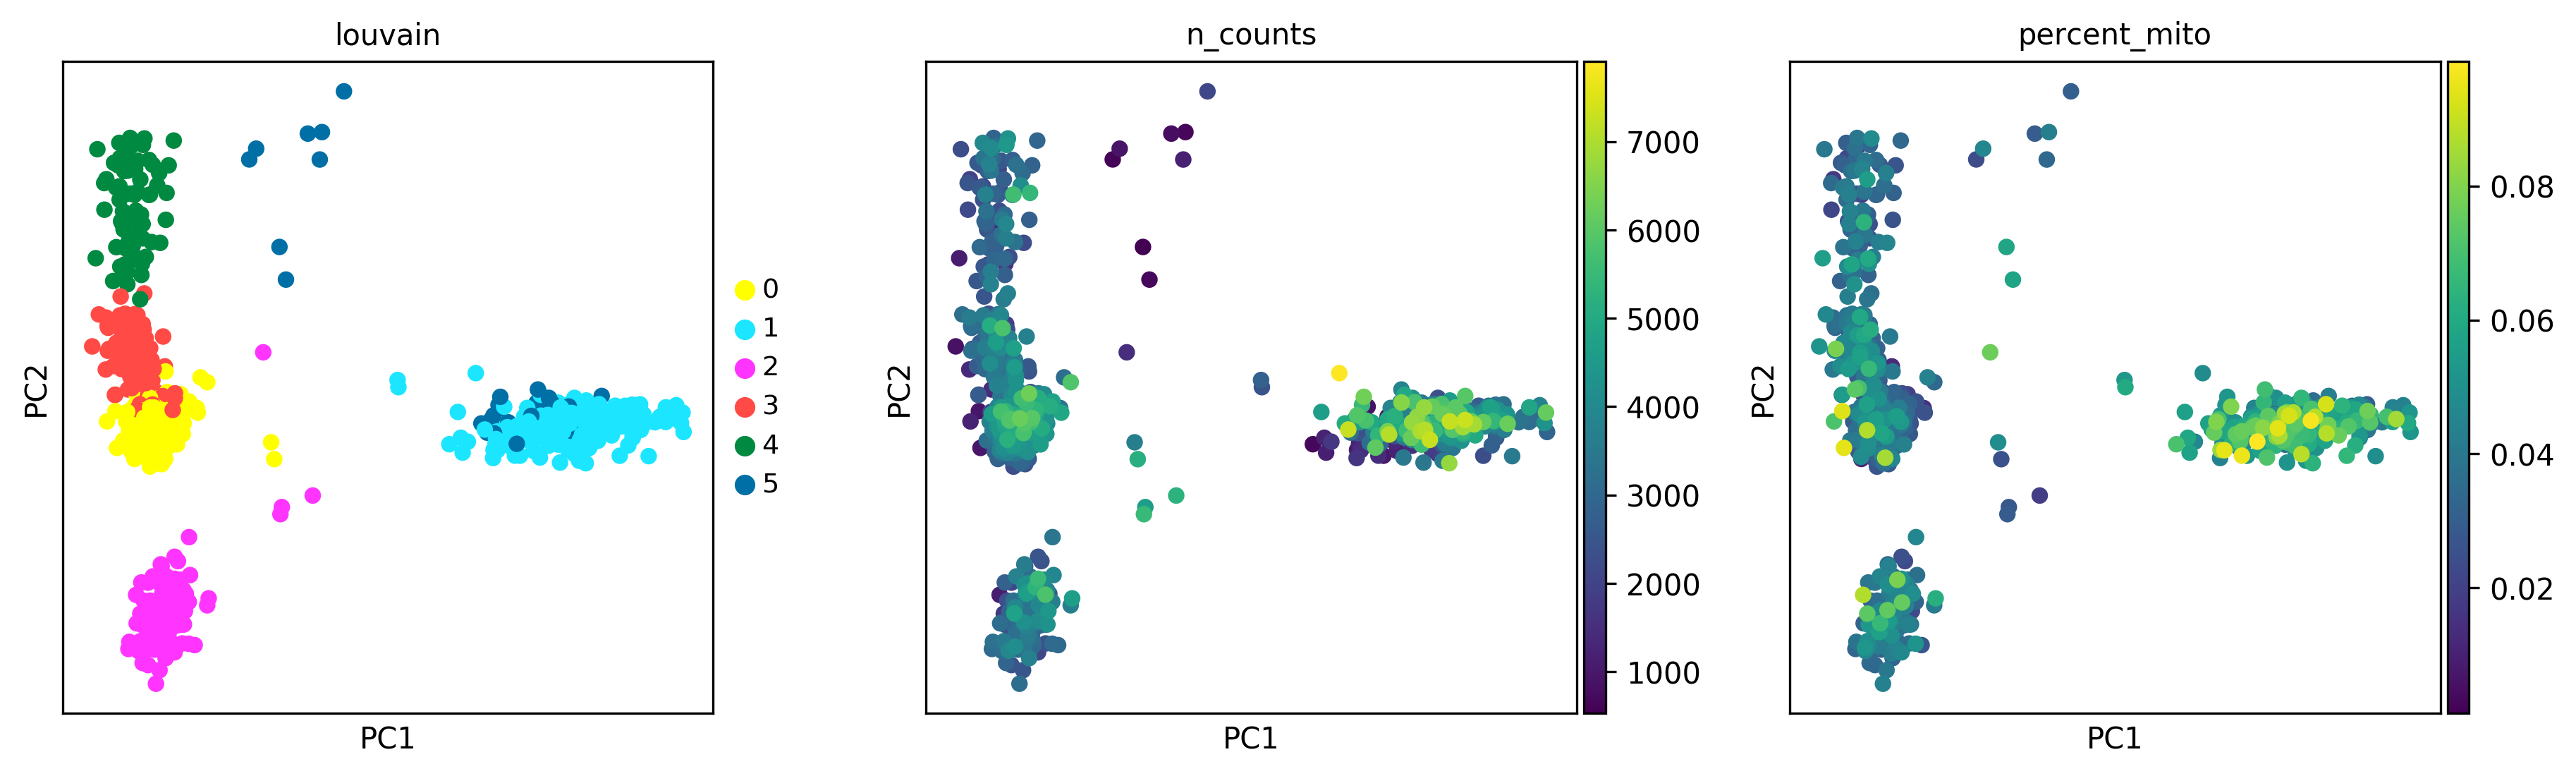

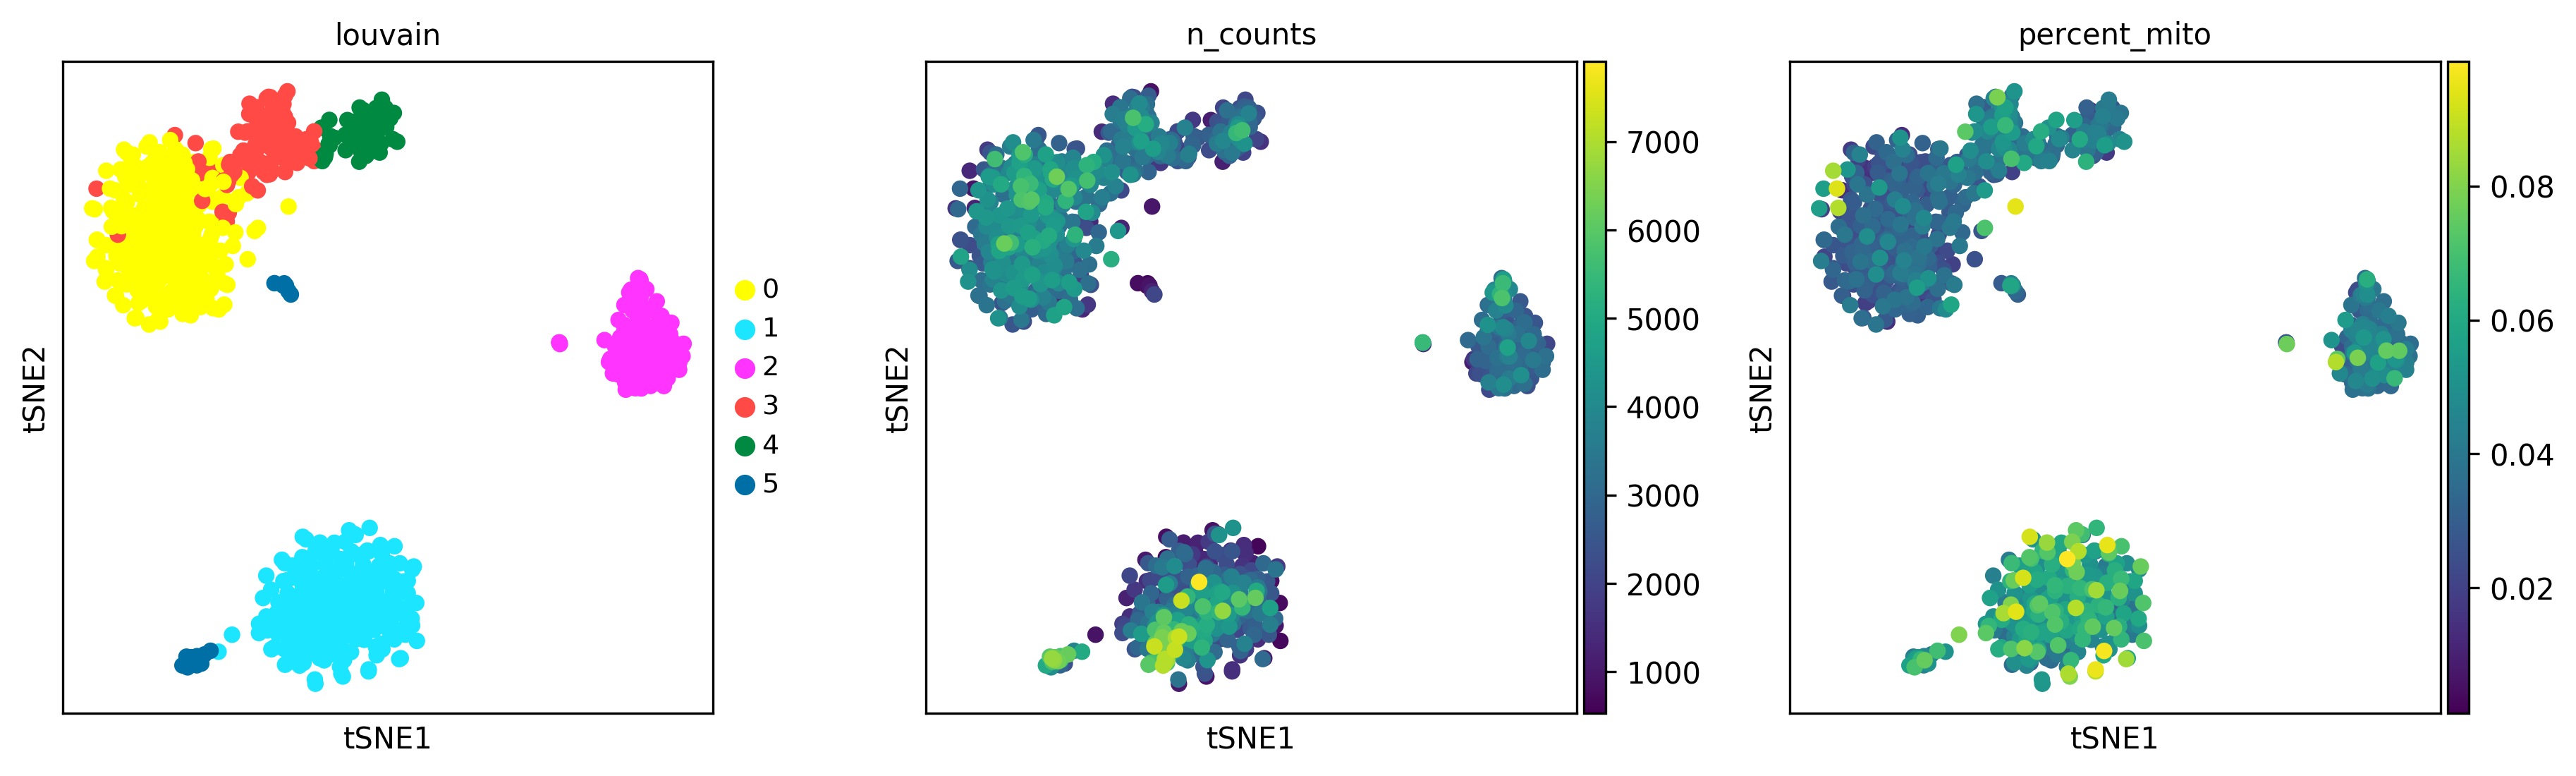

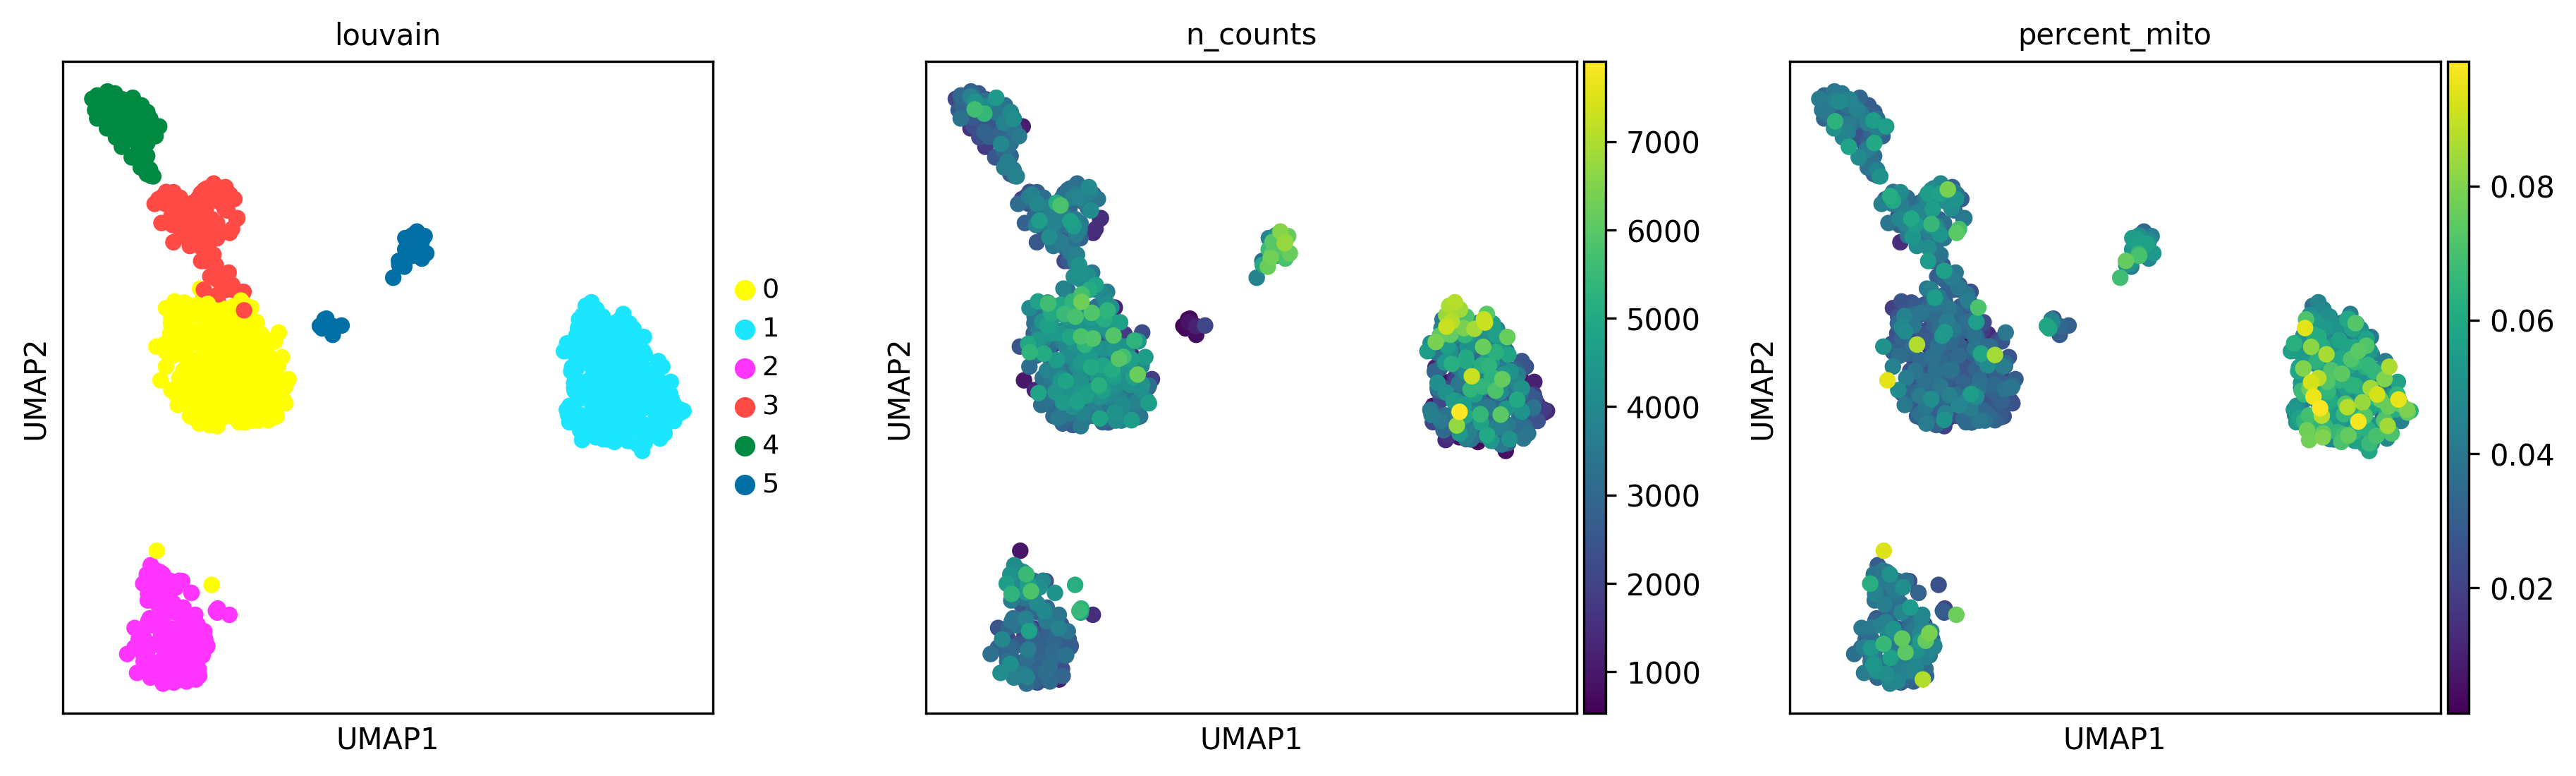

In [6]:
print(f"Louvain resolution: {adata.uns['louvain']['params']['resolution']}")
if('X_pca' in adata.obsm):
    sc.pl.pca(adata, color=features, palette=sc.pl.palettes.default_64)
if('X_tsne' in adata.obsm):
    sc.pl.tsne(adata, color=features, palette=sc.pl.palettes.default_64)
if('X_umap' in adata.obsm):
    sc.pl.umap(adata, color=features, palette=sc.pl.palettes.default_64)